# Boxplot of MZmine 3, PeakDetective, PeakFormer

## MZmine 3 boxplot

In [1]:
import pandas as pd
import numpy as np
import os
import re
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

In [2]:
def filter_data(mzmine_path, benchmark_path, type):
    if type == 'TOF' or type == 'TOFShift':
        keys = ['rt', 'mz', 'rt_range:min', 'rt_range:max',
                'datafile:20170326-960MIX_SampleA_1.mzML:area', 'datafile:20170326-960MIX_SampleA_2.mzML:area',
                'datafile:SampleA_4-20170326-960MIX_SampleA_5.mzML:area',
                'datafile:SampleA_3-20170326-960MIX_SampleA_4.mzML:area',
                'datafile:20170326-960MIX_SampleB_1.mzML:area', 'datafile:20170326-960MIX_SampleB_2.mzML:area',
                'datafile:20170326-960MIX_SampleB_3.mzML:area', 'datafile:20170326-960MIX_SampleB_4.mzML:area'
                ]

    elif type == 'QE' or type == 'QEShift':
        keys = ['rt', 'mz', 'rt_range:min', 'rt_range:max',
                'datafile:SA1.mzML:area', 'datafile:SA2.mzML:area','datafile:SA3.mzML:area', 'datafile:SA4.mzML:area',
                'datafile:SA5.mzML:area','datafile:SB1.mzML:area', 'datafile:SB2.mzML:area','datafile:SB3.mzML:area',
                'datafile:SB4.mzML:area','datafile:SB5.mzML:area'
                ]
    df_mzmine = pd.read_csv(mzmine_path, usecols=keys)
    df_benchmark = pd.read_csv(benchmark_path)
    df_clean = df_mzmine[(df_mzmine != 0).all(axis=1)]  
    df_cleaned = df_clean[df_clean.notnull().all(axis=1)]  
    return df_cleaned, df_benchmark

def find_couple(df_cleaned, df_benchmark, ppm, rtTol=0.5):

    for index, row in df_benchmark.iterrows():

        mz_tolerance = ppm * row["mz"] / 1e6
        mz_bounds = [row["mz"] - mz_tolerance, row["mz"] + mz_tolerance]

        matching_rows \
            = df_cleaned[(df_cleaned["mz"] > mz_bounds[0]) & (df_cleaned["mz"] < mz_bounds[1])]

        matching_match = matching_rows.loc[matching_rows['rt'].between(row['RT'] - rtTol, row['RT'] + rtTol)]

        if matching_rows.empty or matching_match.empty:
            df_benchmark.at[index, 'tag'] = 0
        else:
            for i, row1 in matching_match.iterrows():
                df_cleaned.at[i, 'True RT'] = row['RT']
                df_cleaned.at[i, 'Compound Name'] = int(row['Compound Name'])
                df_cleaned.at[i, 'Fold change'] = row['Fold change']
                df_cleaned.at[i, 'Compound concentration ratio'] = row['Compound concentration ratio']

    return df_cleaned, df_benchmark

def plot_venn(df1, df2, type, name):
    set1 = set(df1['Compound Name'])
    set2 = set(df2['Compound Name'])
    venn2([set1, set2],
          set_labels=["mzmine", "benchmark"], set_colors=["green", "grey"])
    plt.tight_layout()
    # plt.savefig(f"{type}+{name}.png", dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()


def plot_boxplot(df, name, type, precision, lim, n='fc'):
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    graph = ax.boxplot(
        [
            df[df["Compound concentration ratio"] == "1/16"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/4"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/2"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "2/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "4/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "16/1"].loc[:, n],
        ],
        vert=True,
        patch_artist=True,
        labels=["Gd1", "Gd2", "Gd3", "Gdm", "Gd4", "Gd5", "Gd6"],
        sym='*'
    )

    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(graph['boxes'], colors):
        patch.set_facecolor(color)
    plt.tight_layout()

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    plt.yscale('log', base=2)
    import numpy as np
    if lim!=0:
        plt.ylim(1 / 2 ** lim,  2 ** lim)
    ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    # plt.savefig(f"{type}+{name}+{precision}.png", dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()


def compute_average_and_cv(group_name, column_names, df):
    try:
        group_columns = [f'{column_name}' for column_name in column_names]

        relevant_data = df.select_dtypes(include='number')[group_columns]

        avg = relevant_data.mean(axis=1)
        std = relevant_data.std(axis=1)


        cv = std.where(std != 0, 0) / avg * 100

        return {'AVG': avg, 'CV': cv}
    except Exception as e:
        print(f"Error processing group {group_name}: {e}")
        return {}


def plot_log(df1, type, name, save=False, lim=0):
    df1 = df1[df1.notnull().all(axis=1)] 
    if type == 'TOF' or type == 'TOFShift':
        import pandas as pd

        sample_a_columns = ['datafile:20170326-960MIX_SampleA_1.mzML:area',
                            'datafile:20170326-960MIX_SampleA_2.mzML:area',
                            'datafile:SampleA_4-20170326-960MIX_SampleA_5.mzML:area',
                            'datafile:SampleA_3-20170326-960MIX_SampleA_4.mzML:area']

        sample_b_columns = ['datafile:20170326-960MIX_SampleB_1.mzML:area',
                            'datafile:20170326-960MIX_SampleB_2.mzML:area',
                            'datafile:20170326-960MIX_SampleB_3.mzML:area',
                            'datafile:20170326-960MIX_SampleB_4.mzML:area']
    elif type == 'QE' or type == 'QEShift':
        sample_a_columns = ['datafile:SA1.mzML:area', 'datafile:SA2.mzML:area',
                            'datafile:SA3.mzML:area', 'datafile:SA4.mzML:area',
                            'datafile:SA5.mzML:area']
        sample_b_columns = ['datafile:SB1.mzML:area', 'datafile:SB2.mzML:area',
                            'datafile:SB3.mzML:area', 'datafile:SB4.mzML:area',
                            'datafile:SB5.mzML:area']

    sample_a_results = compute_average_and_cv('SampleA', sample_a_columns, df1)
    sample_b_results = compute_average_and_cv('SampleB', sample_b_columns, df1)

    df1.loc[:, 'AVG-A'] = sample_a_results['AVG']
    df1.loc[:, 'CV-A'] = sample_a_results['CV']
    df1.loc[:, 'AVG-B'] = sample_b_results['AVG']
    df1.loc[:, 'CV-B'] = sample_b_results['CV']

    df1.loc[:, 'fc'] = df1.loc[:, 'AVG-B'] / df1.loc[:, 'AVG-A']
    df1.loc[:, 'ratio'] = df1.loc[:, 'fc'] / df1.loc[:, 'Fold change']

    df1 = df1.sort_values(by='Compound Name')
    duplicate_rows = df1[df1.duplicated(subset=['Compound Name'], keep=False)]
    from itertools import groupby
    grouped = [(key, list(group)) for key, group in
                groupby(duplicate_rows.index, key=lambda x: duplicate_rows.loc[x, duplicate_rows.columns[-9]])]

    other_numbers_in_group = []
    for key, group in grouped:
        min_id = min(group, key=lambda x: (abs(duplicate_rows.loc[x, 'rt'] - duplicate_rows.loc[x, 'True RT'])))


        for id in group:
            if id != min_id:
                other_numbers_in_group.append(id)

    df1.drop(other_numbers_in_group, inplace=True)

    score = calculate_precision(df1, name, type)
    print(score)
    plot_boxplot(df1, name, type, score,lim)
    if save:
        df1.to_csv(f'{type}.csv', index=False)


def calculate_precision(df, name, type):
    print(f'{type}+{name}')
    df_filtered = df[(df['ratio'] > 0.8) & (df['ratio'] < 1.2)]
    count = df_filtered.shape[0]
    print(f"precise quantify:{count}")
    print(f"count:{df.shape[0]}",)
    print(f"precsion:{count/df.shape[0]}")
    if type == 'TOF' or type == 'TOFShift':
        return round((count/df.shape[0] + df.shape[0] / 970)/2, 3)
    elif type == 'QE' or type == 'QEShift':
        return round((count/df.shape[0] + df.shape[0] / 836)/2, 3)

In [3]:
def boxplot(mzmine_dir, benchmark_path, type):
    for mzmine_path in os.listdir(mzmine_dir):
        mzmine_path = os.path.join(mzmine_dir, mzmine_path)

        df1, df2 = filter_data(mzmine_path, benchmark_path, type)
        match = re.search(r'-(\d+)-(\d+\.\d+)', mzmine_path)
        if match:
            number1 = int(match.group(1)) 
            number2 = float(match.group(2)) 
            df1, df2 = find_couple(df1, df2, number1, number2)
            plot_venn(df1, df2, type, name=number1 + number2)
            plot_log(df1, type, name=number1 + number2,lim=0)

### Ground Truth

/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


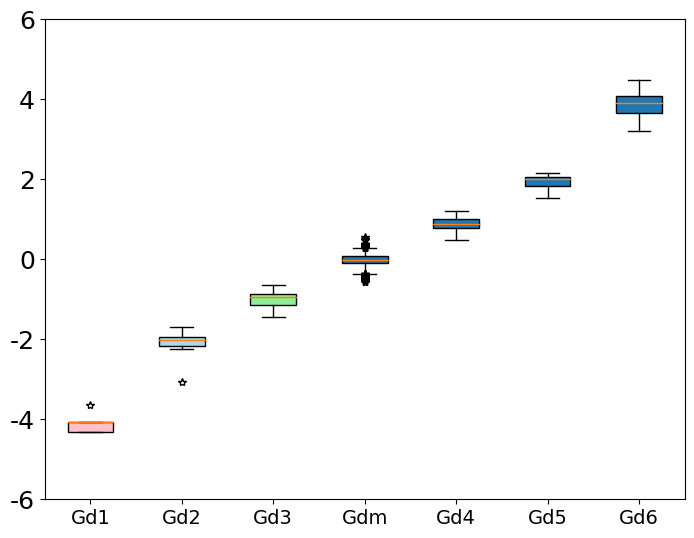

In [4]:
benchmark_path = 'data/FeatureQE.csv'
type = 'QE'
df1 = pd.read_csv(benchmark_path)
plot_boxplot(df1, name='QE', type='QE', precision=0, lim=6,n='Fold change')

### QE-benchmark feature table

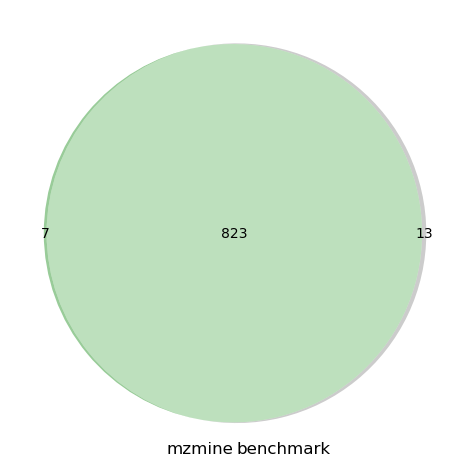

QE+10.3
precise quantify:784
count:823
precsion:0.9526123936816525
0.969


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


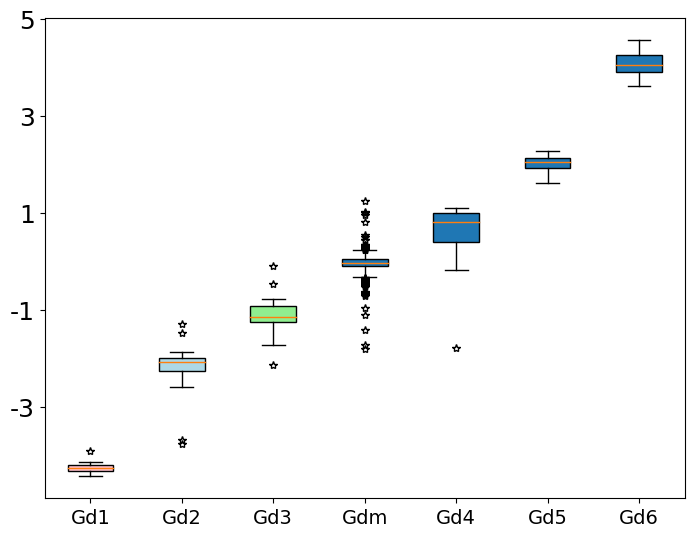

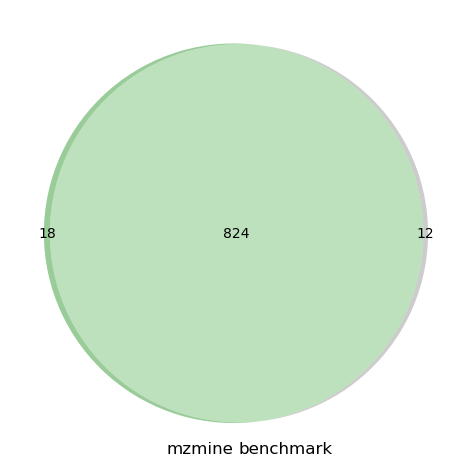

QE+15.4
precise quantify:784
count:824
precsion:0.9514563106796117
0.969


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


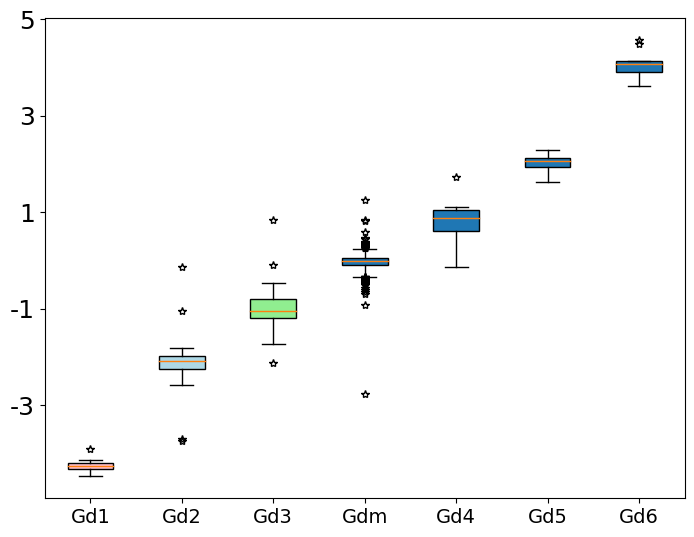

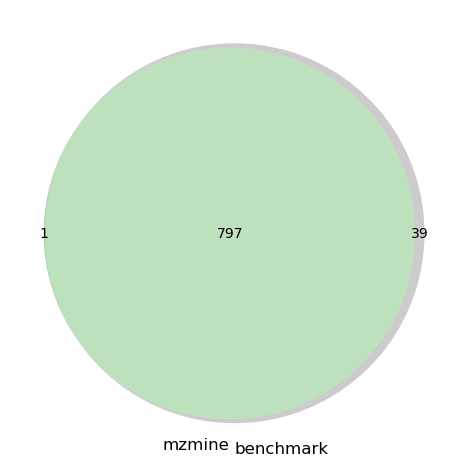

QE+10.1
precise quantify:609
count:797
precsion:0.7641154328732748
0.859


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


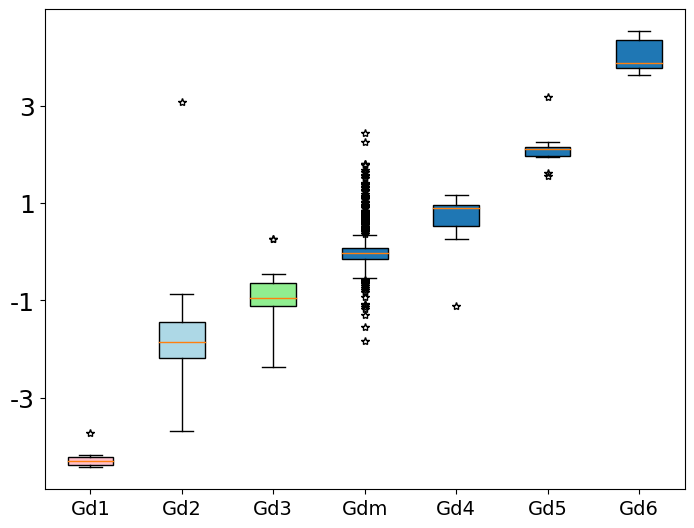

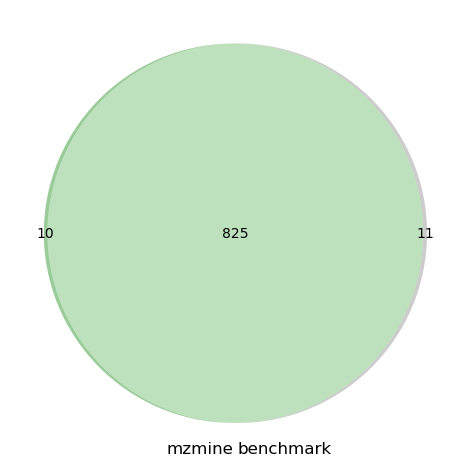

QE+15.3
precise quantify:789
count:825
precsion:0.9563636363636364
0.972


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


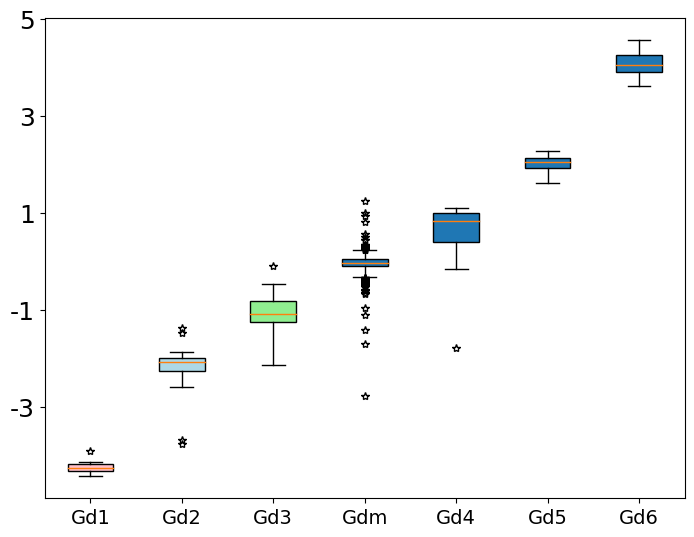

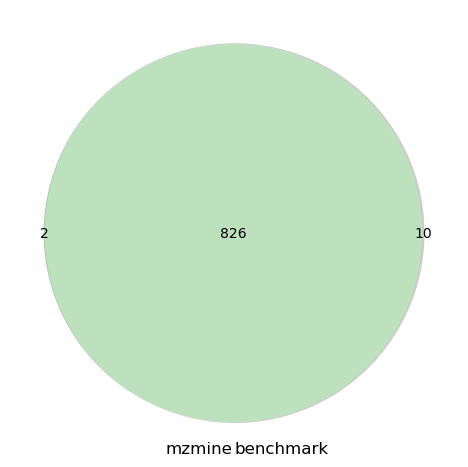

QE+10.2
precise quantify:748
count:826
precsion:0.9055690072639225
0.947


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


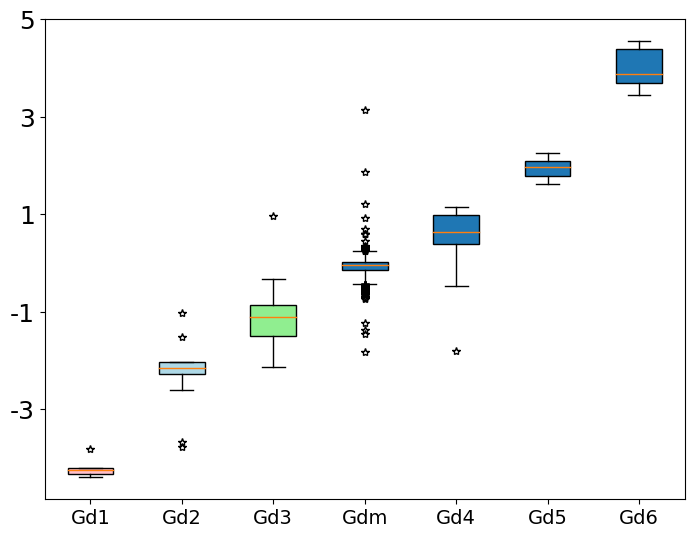

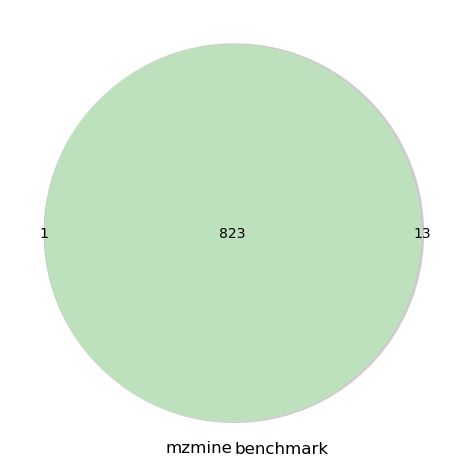

QE+5.3
precise quantify:783
count:823
precsion:0.951397326852977
0.968


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


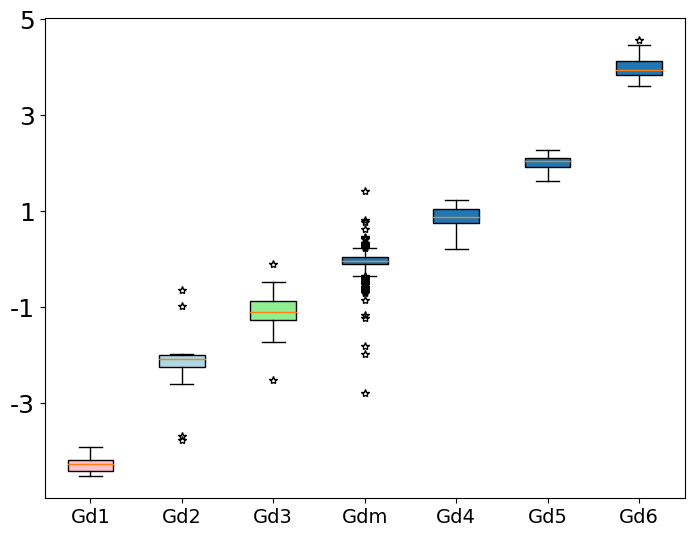

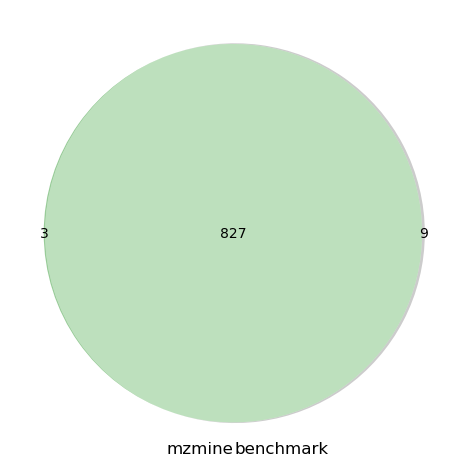

QE+15.2
precise quantify:749
count:827
precsion:0.905683192261185
0.947


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


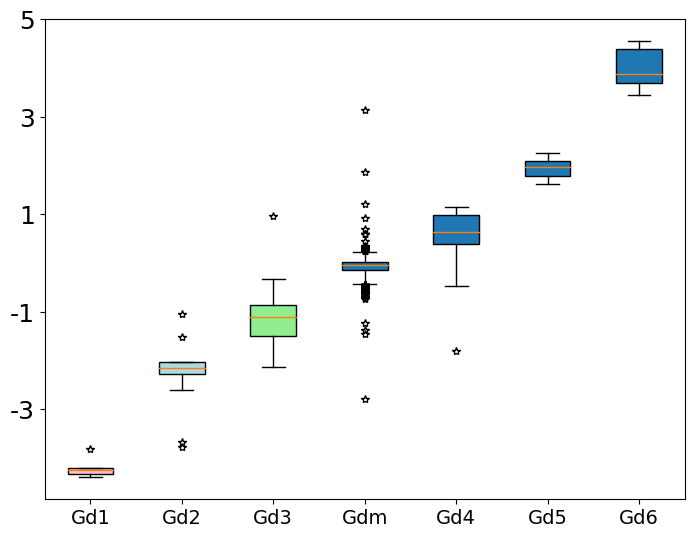

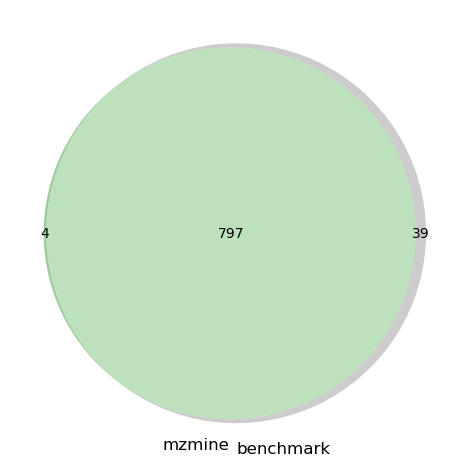

QE+15.1
precise quantify:610
count:797
precsion:0.7653701380175659
0.859


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


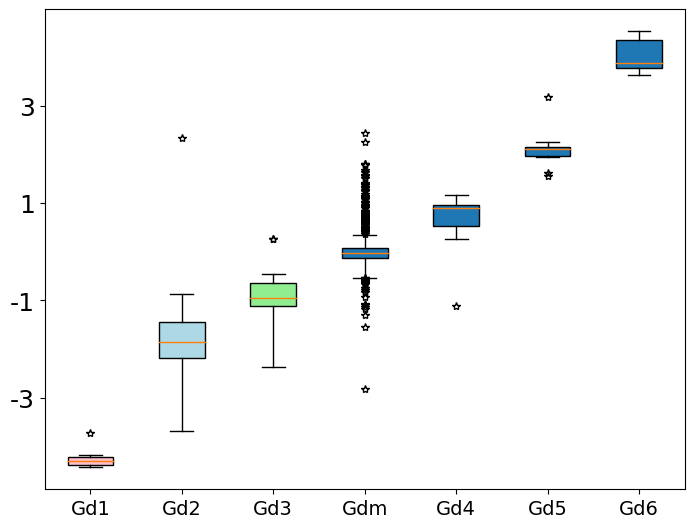

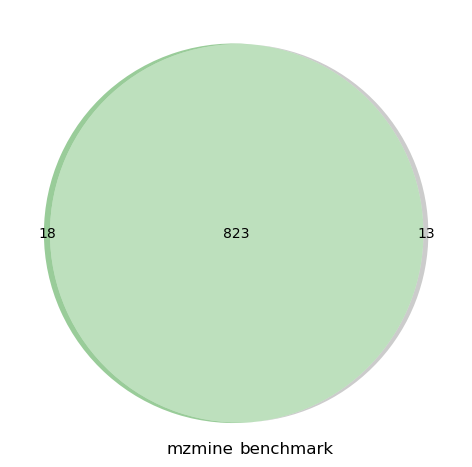

QE+15.5
precise quantify:777
count:823
precsion:0.9441069258809235
0.964


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


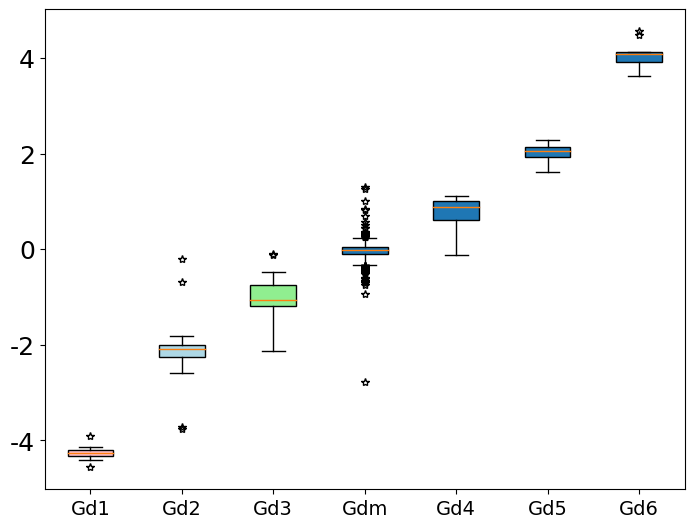

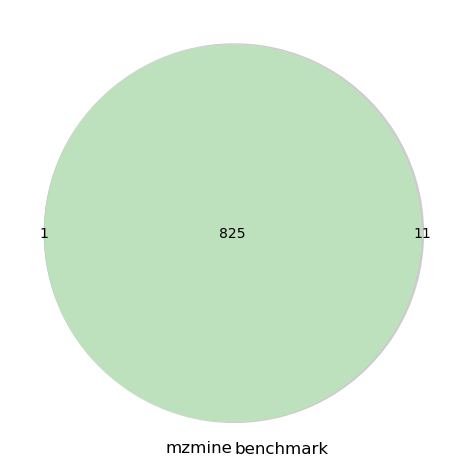

QE+5.2
precise quantify:748
count:825
precsion:0.9066666666666666
0.947


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


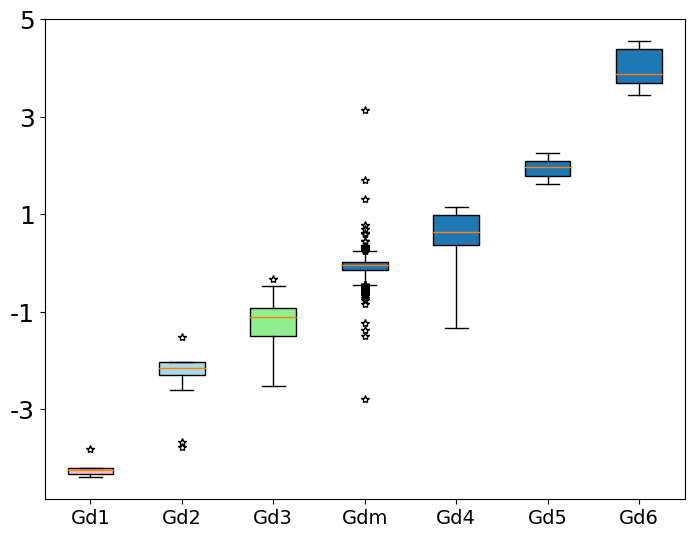

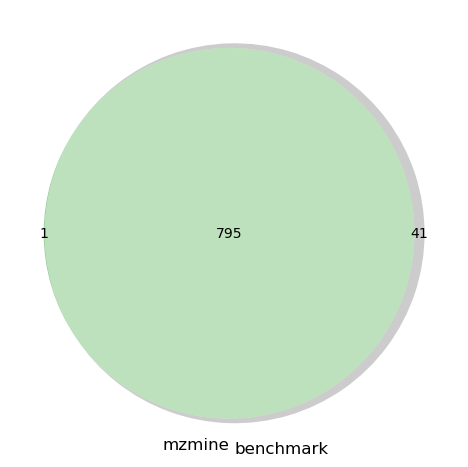

QE+5.1
precise quantify:614
count:795
precsion:0.7723270440251573
0.862


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


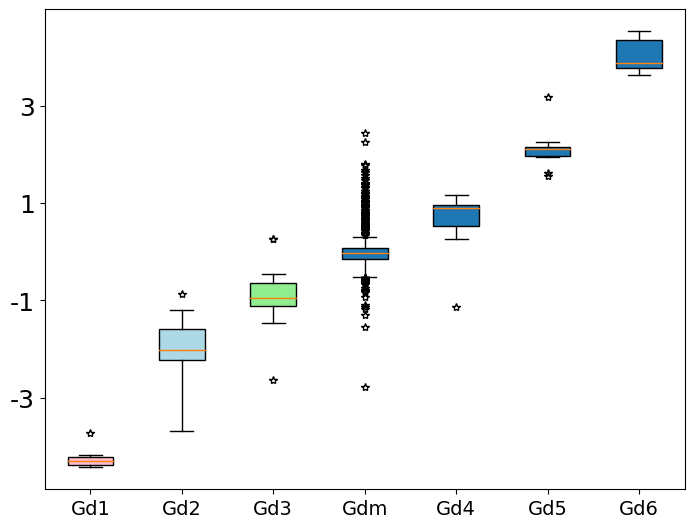

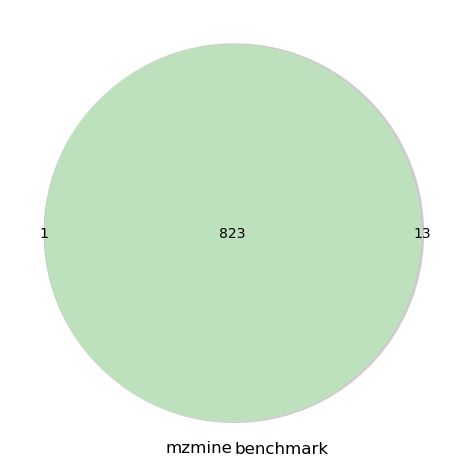

QE+5.5
precise quantify:747
count:823
precsion:0.9076549210206561
0.946


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


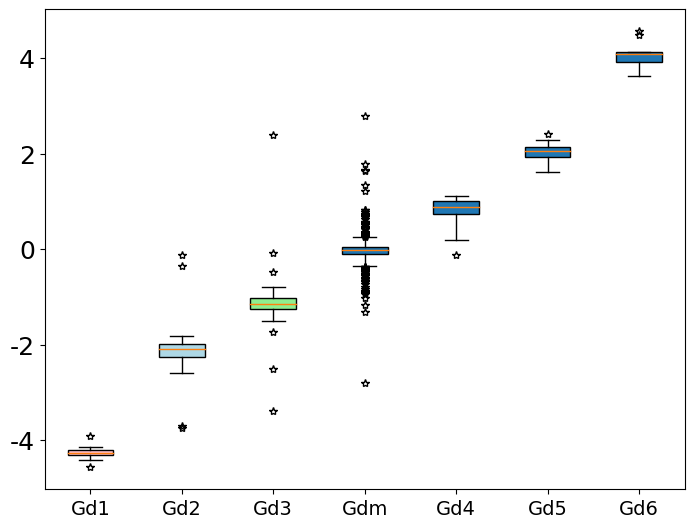

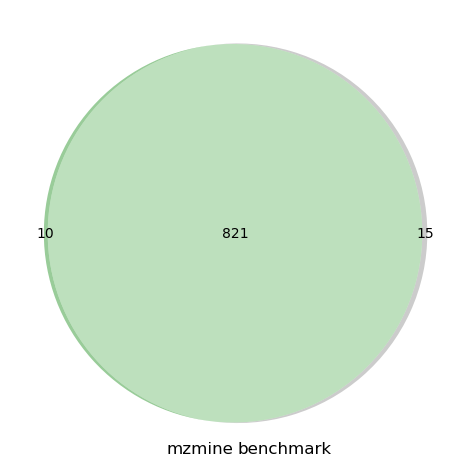

QE+10.5
precise quantify:766
count:821
precsion:0.9330085261875761
0.958


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


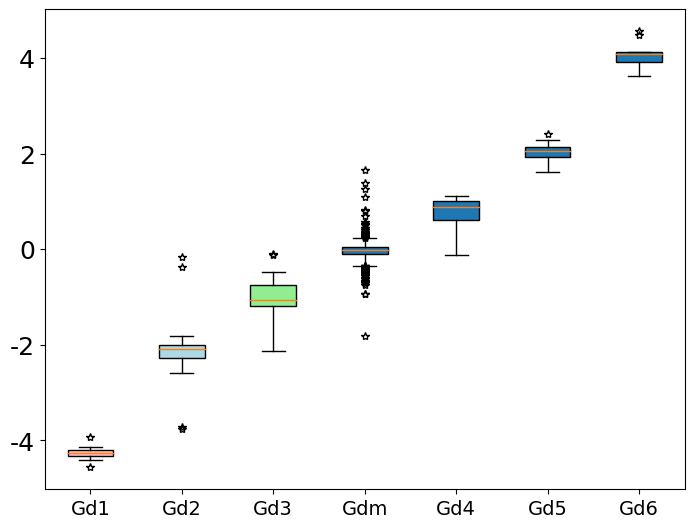

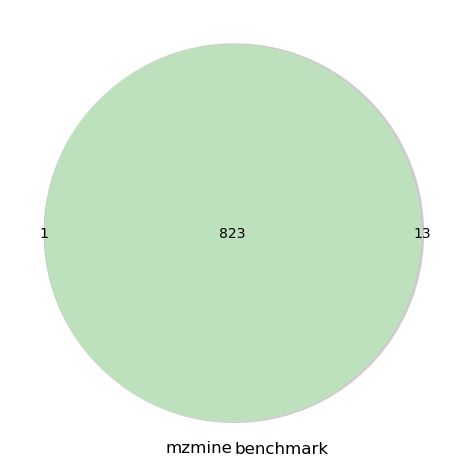

QE+5.4
precise quantify:765
count:823
precsion:0.9295261239368166
0.957


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


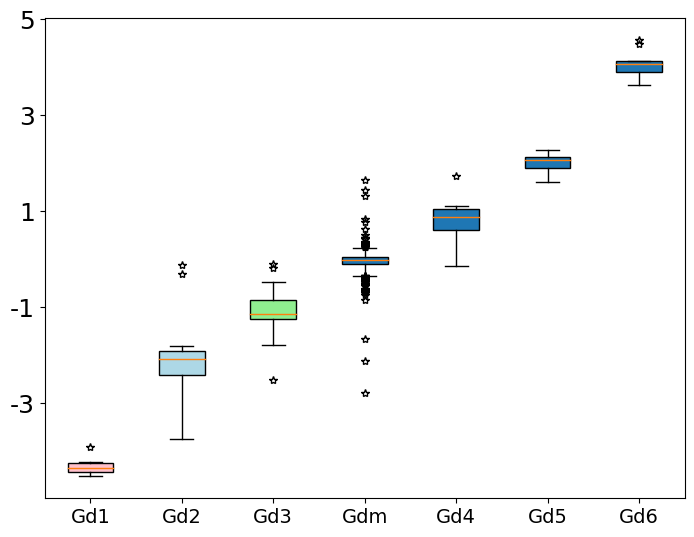

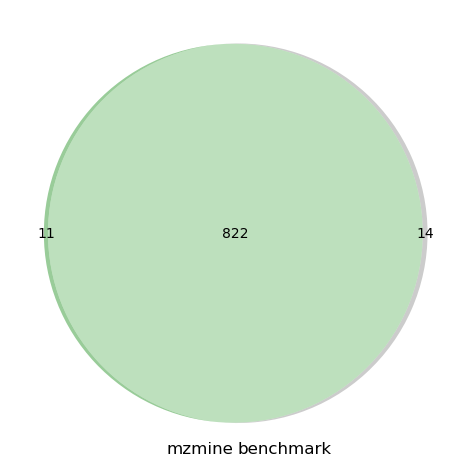

QE+10.4
precise quantify:780
count:822
precsion:0.948905109489051
0.966


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


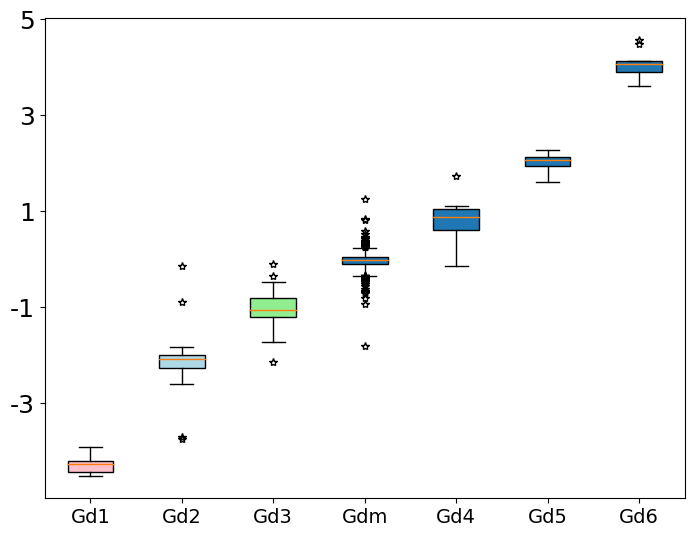

In [5]:
mzmine_dir = 'data/MZMINE3/QE-raw'
benchmark_path = 'data/FeatureQE.csv'
type = 'QE'
boxplot(mzmine_dir, benchmark_path, type)

#### The best is 15.3, which means ppm=15, rt_tolerance = 0.3

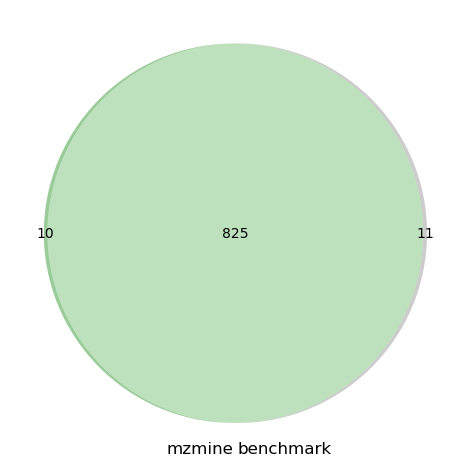

QE+15.3
precise quantify:789
count:825
precsion:0.9563636363636364
0.972


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


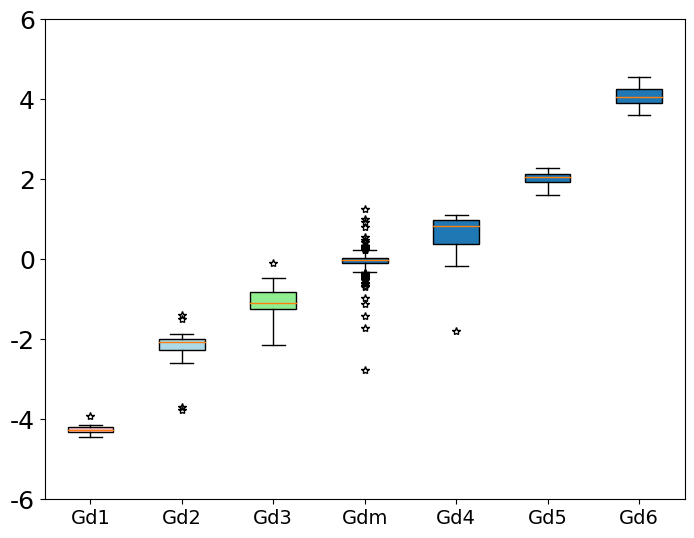

In [6]:
mzmine_path = 'data/MZMINE3/QE-raw/Aligned_feature_list_gap-filled-15-0.3.csv'
def plot_best(mzmine_path, benchmark_path, type):
    df1, df2 = filter_data(mzmine_path, benchmark_path, type)
    match = re.search(r'-(\d+)-(\d+\.\d+)', mzmine_path)
    if match:
        number1 = int(match.group(1)) 
        number2 = float(match.group(2)) 
        df1, df2 = find_couple(df1, df2, number1, number2)
        plot_venn(df1, df2, type, name=number1 + number2)
        plot_log(df1, type, name=number1 + number2, lim=6, save=True)
plot_best(mzmine_path, benchmark_path, type)

### QE- feature table with RT drift

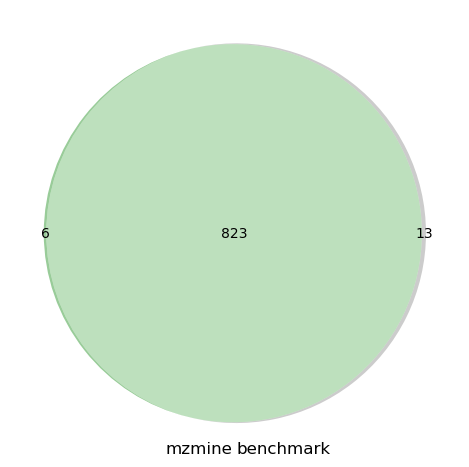

QEShift+10.3
precise quantify:686
count:823
precsion:0.8335358444714459
0.909


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


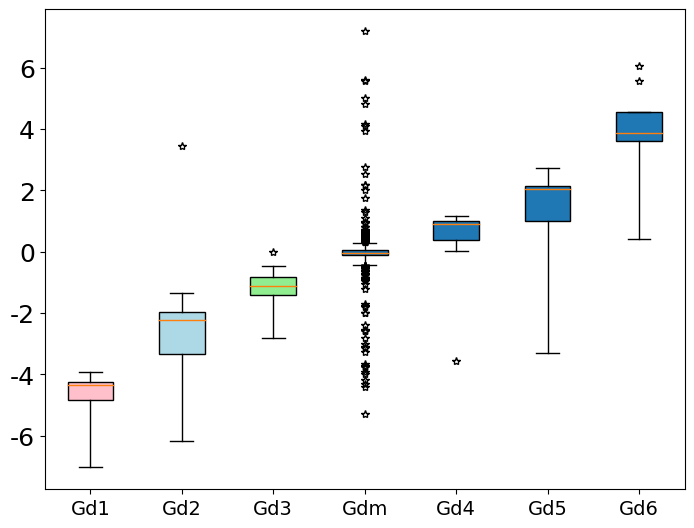

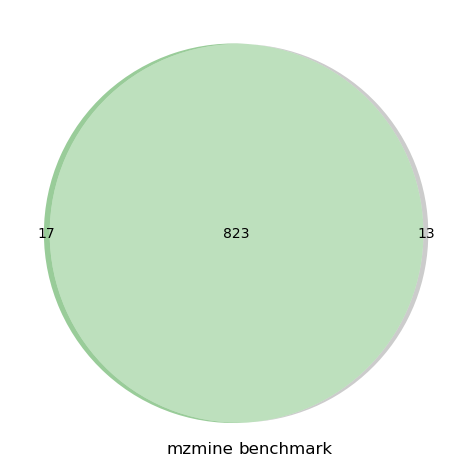

QEShift+15.4
precise quantify:687
count:823
precsion:0.8347509113001215
0.91


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


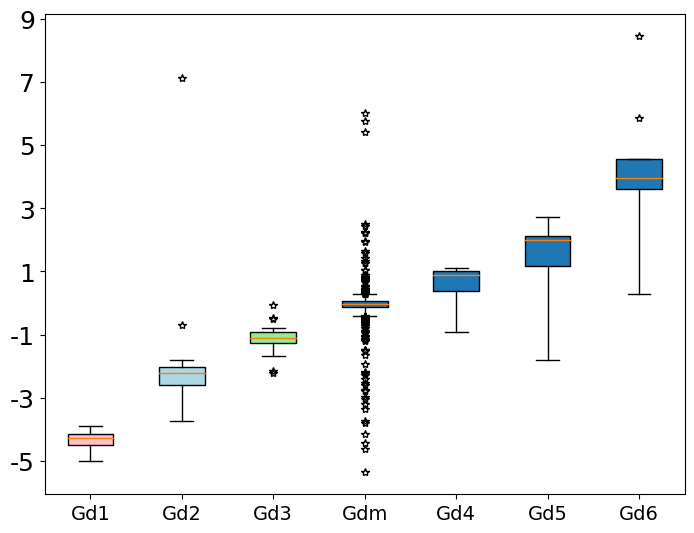

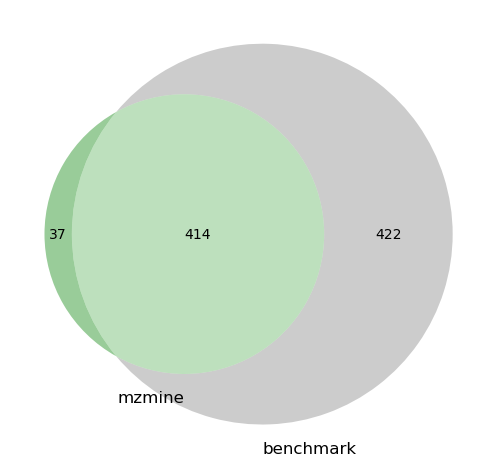

QEShift+10.1
precise quantify:225
count:414
precsion:0.5434782608695652
0.519


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


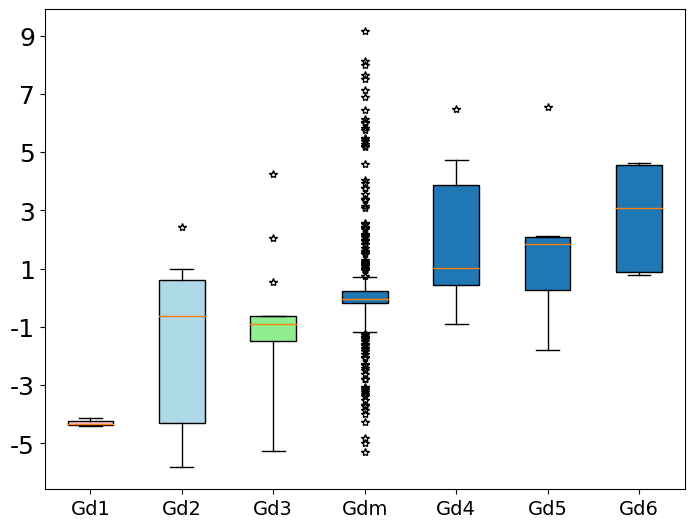

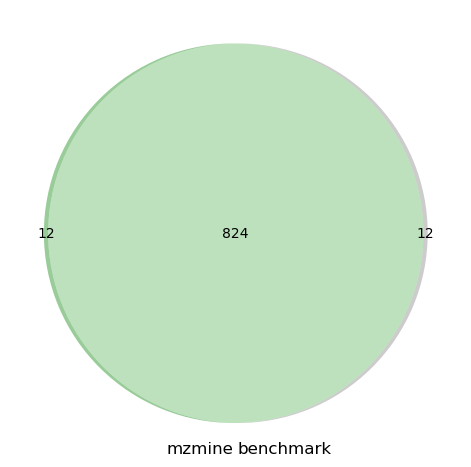

QEShift+15.3
precise quantify:690
count:824
precsion:0.837378640776699
0.912


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


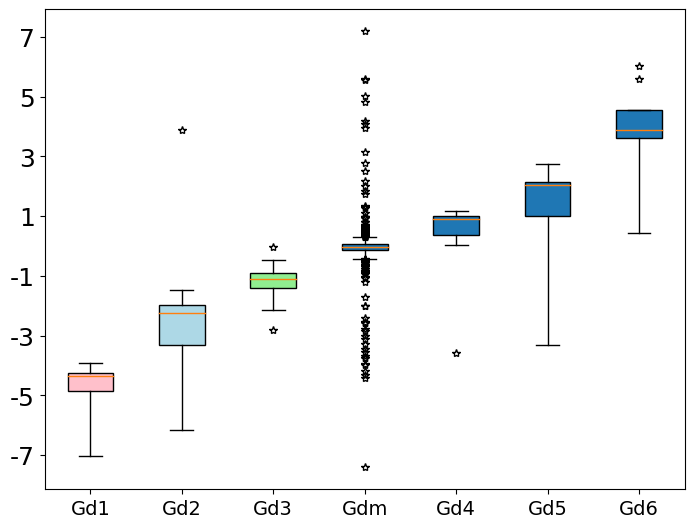

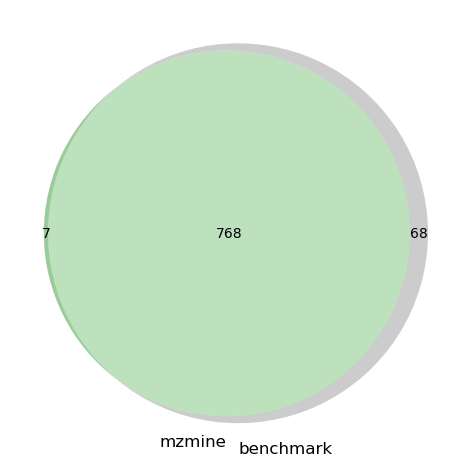

QEShift+10.2
precise quantify:572
count:768
precsion:0.7447916666666666
0.832


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


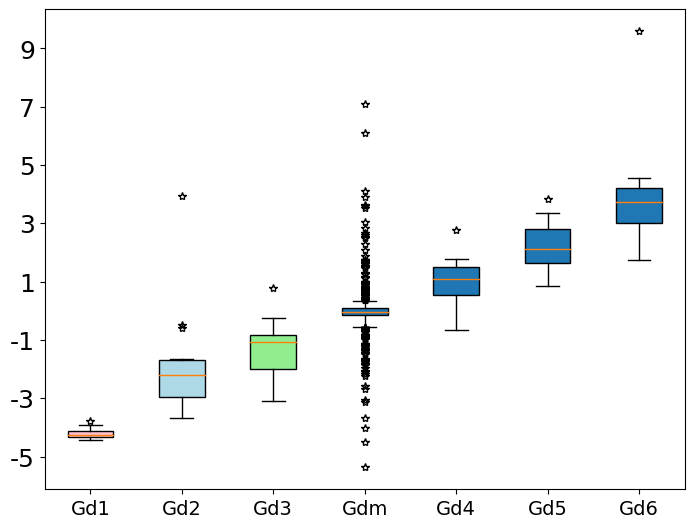

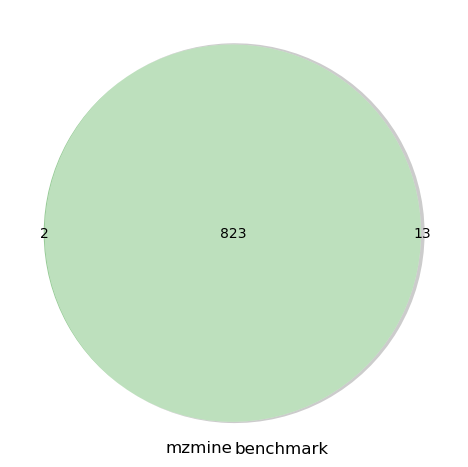

QEShift+5.3
precise quantify:673
count:823
precsion:0.8177399756986634
0.901


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


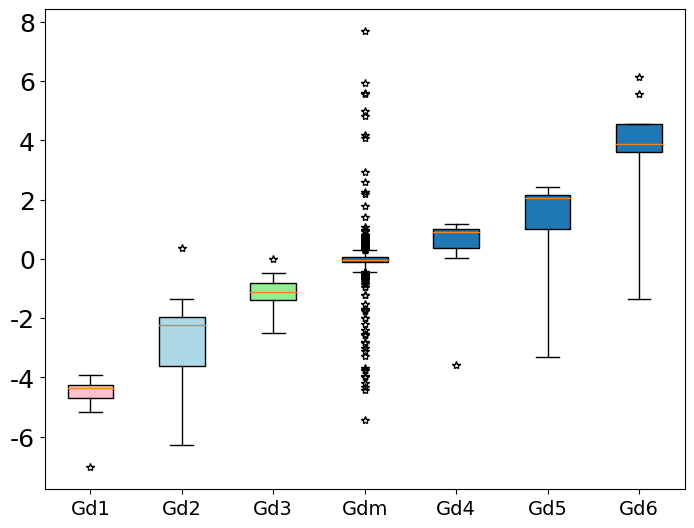

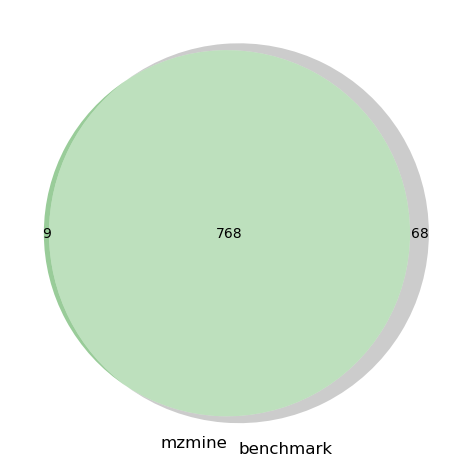

QEShift+15.2
precise quantify:570
count:768
precsion:0.7421875
0.83


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


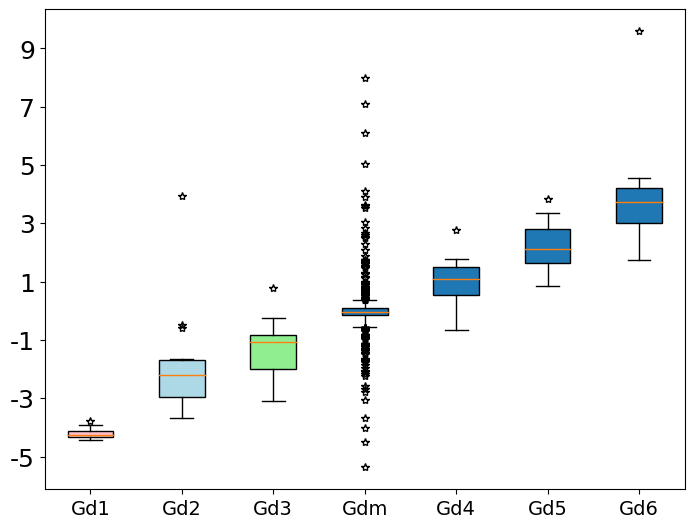

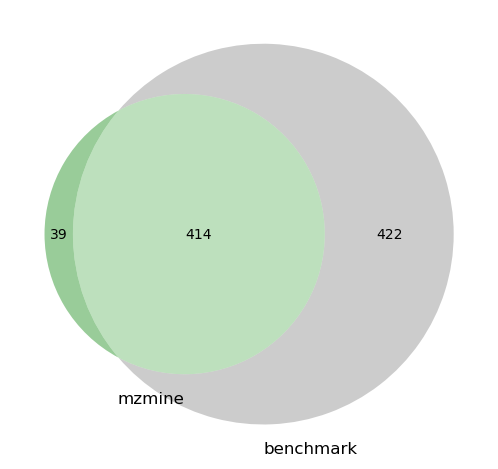

QEShift+15.1
precise quantify:226
count:414
precsion:0.5458937198067633
0.521


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


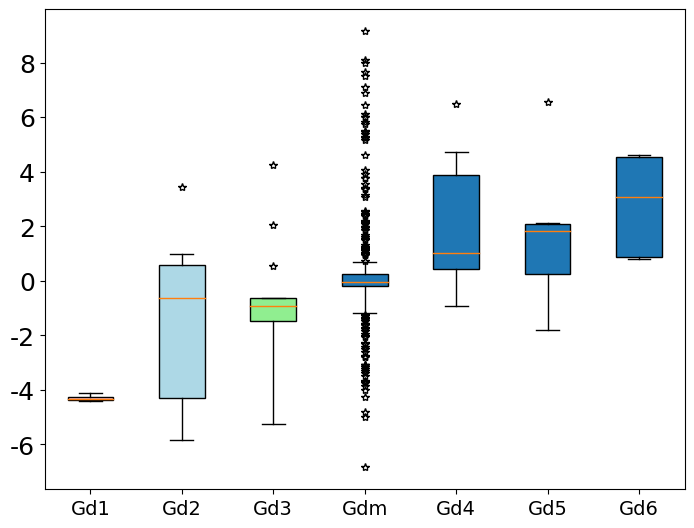

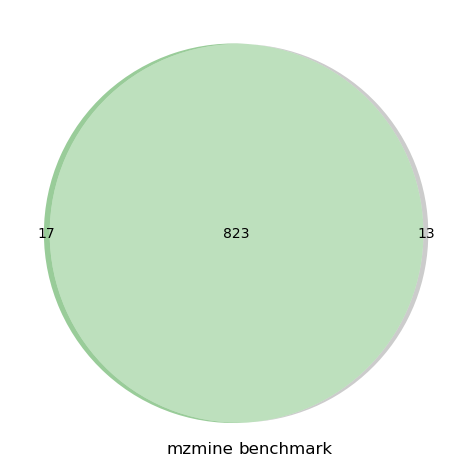

QEShift+15.5
precise quantify:673
count:823
precsion:0.8177399756986634
0.901


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


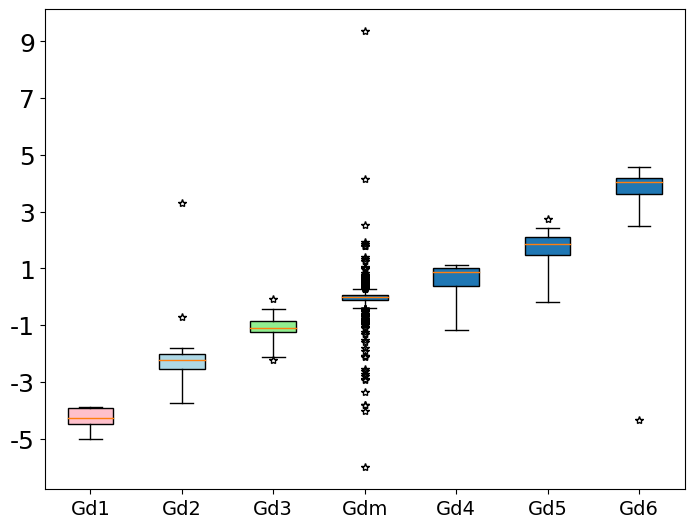

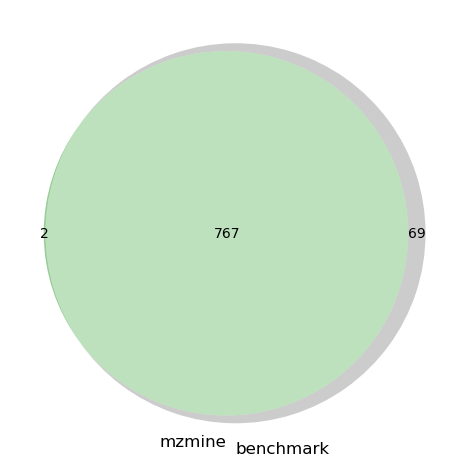

QEShift+5.2
precise quantify:565
count:767
precsion:0.7366362451108214
0.827


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


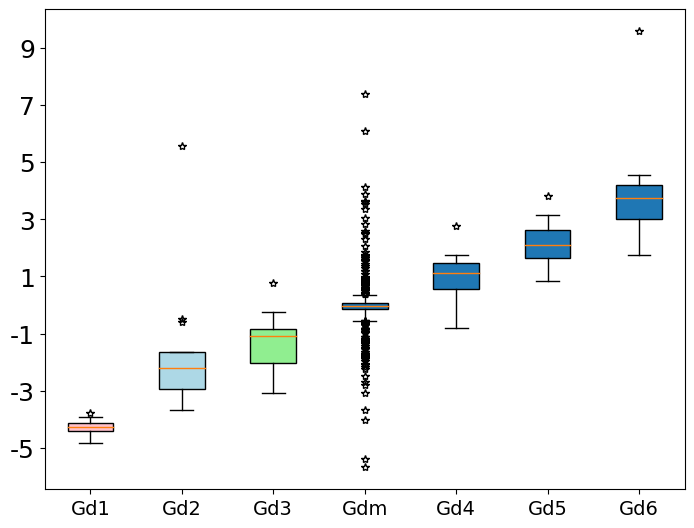

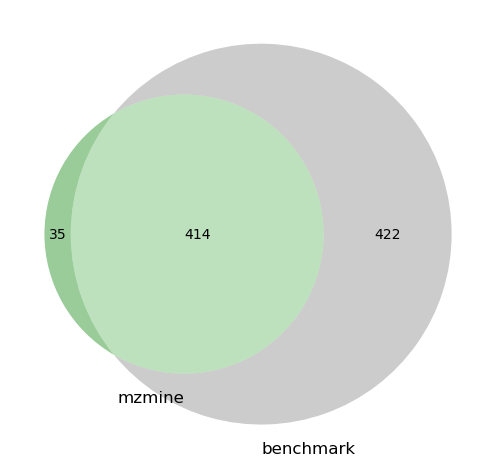

QEShift+5.1
precise quantify:219
count:414
precsion:0.5289855072463768
0.512


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


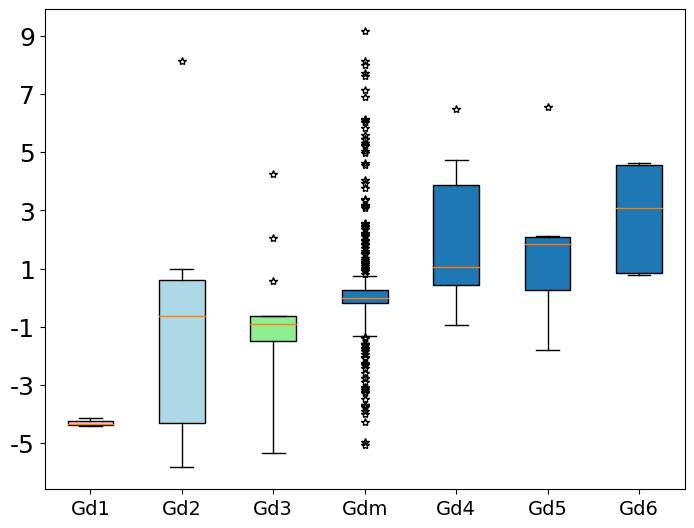

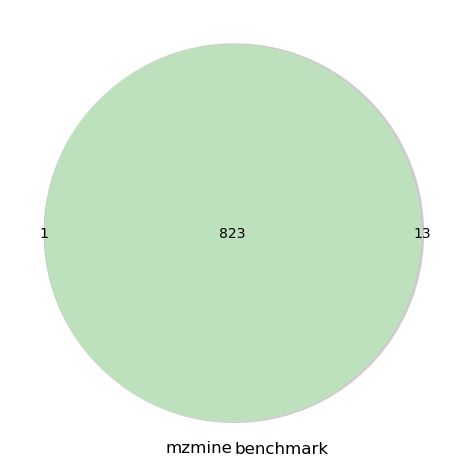

QEShift+5.5
precise quantify:651
count:823
precsion:0.7910085054678008
0.888


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


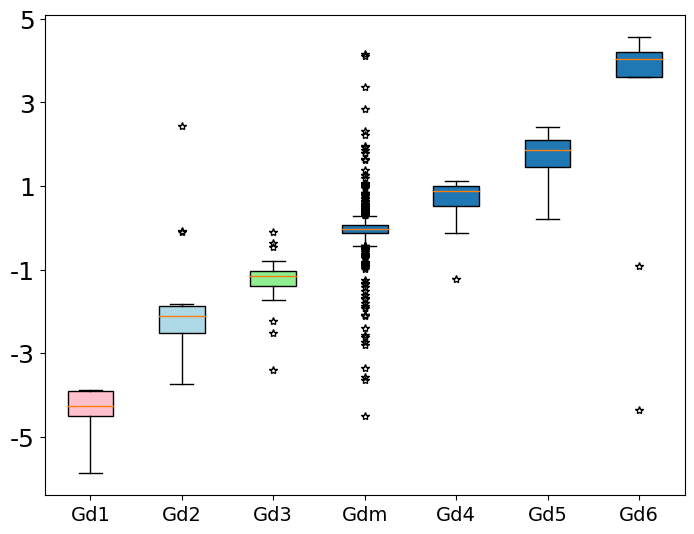

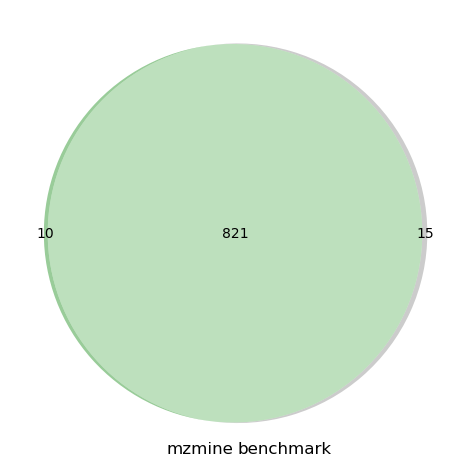

QEShift+10.5
precise quantify:664
count:821
precsion:0.8087697929354446
0.895


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


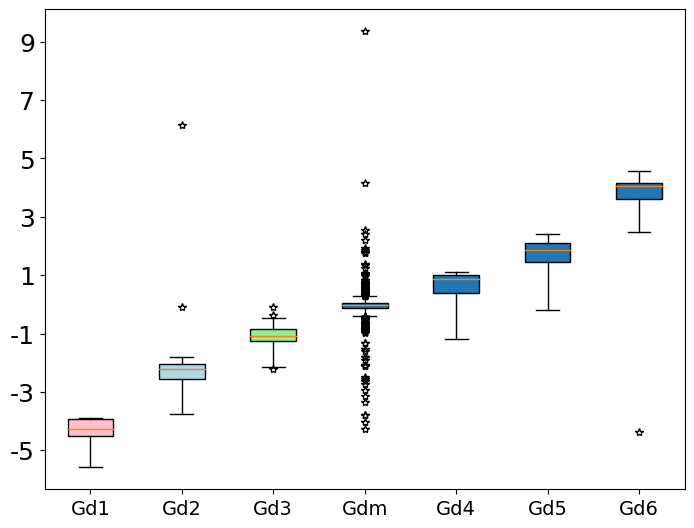

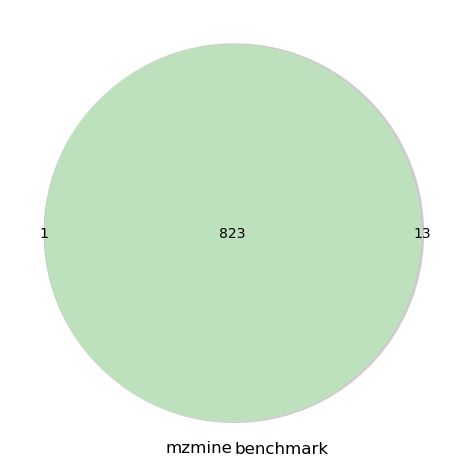

QEShift+5.4
precise quantify:667
count:823
precsion:0.81044957472661
0.897


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


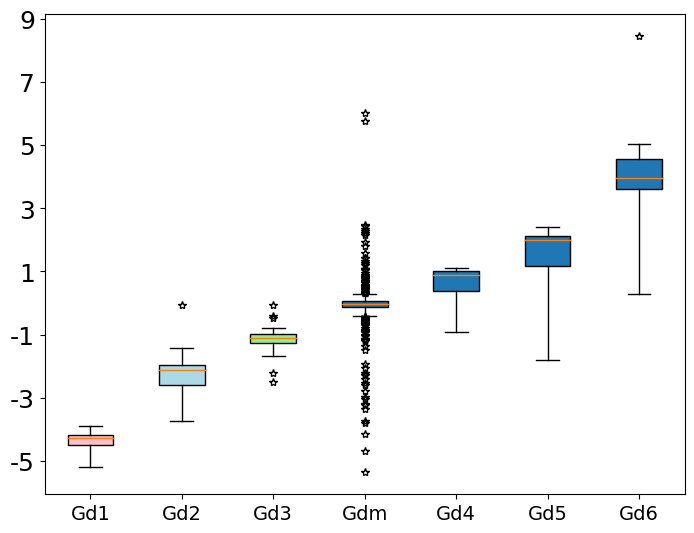

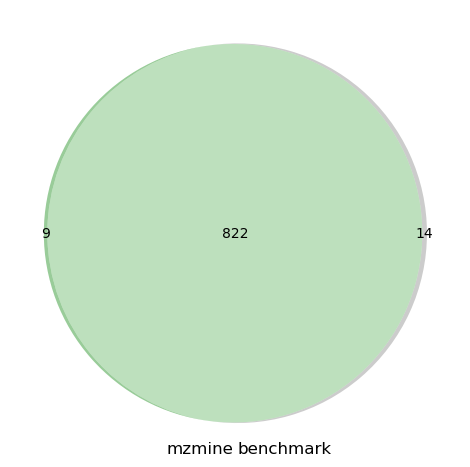

QEShift+10.4
precise quantify:680
count:822
precsion:0.8272506082725061
0.905


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


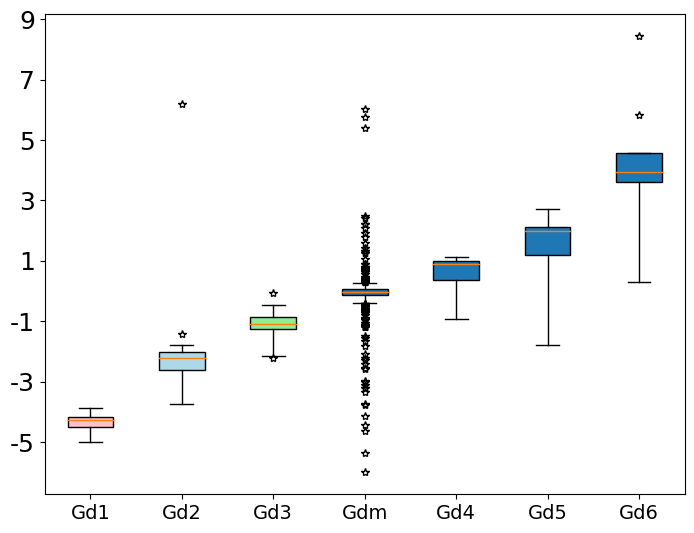

In [7]:
mzmine_dir = 'data/MZMINE3/QEShift-raw'
benchmark_path = 'data/FeatureQEShift.csv'
type = 'QEShift'
boxplot(mzmine_dir, benchmark_path, type)

### The best is 15.3, which means ppm=15, rt_tolerance = 0.3

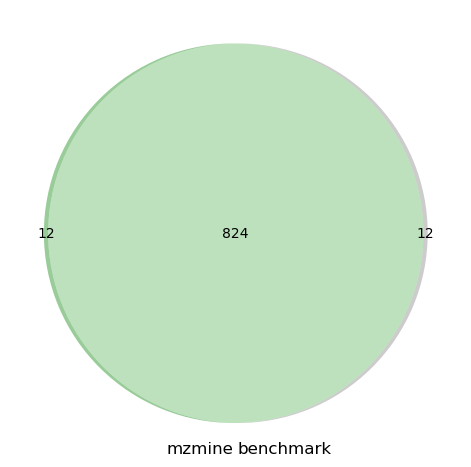

QEShift+15.3
precise quantify:690
count:824
precsion:0.837378640776699
0.912


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


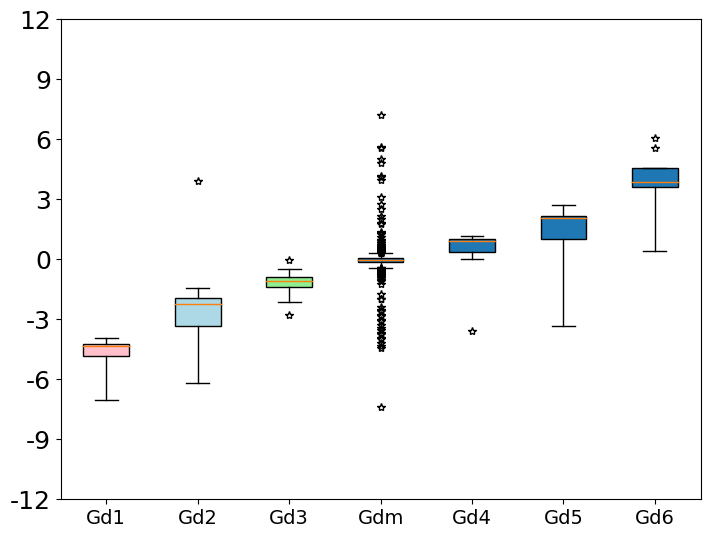

In [8]:
mzmine_path = 'data/MZMINE3/QEShift-raw/Aligned_feature_list_gap-filled-15-0.3.csv'
def plot_best(mzmine_path, benchmark_path, type):
    df1, df2 = filter_data(mzmine_path, benchmark_path, type)
    match = re.search(r'-(\d+)-(\d+\.\d+)', mzmine_path)
    if match:
        number1 = int(match.group(1)) 
        number2 = float(match.group(2)) 
        df1, df2 = find_couple(df1, df2, number1, number2)
        plot_venn(df1, df2, type, name=number1 + number2)
        plot_log(df1, type, name=number1 + number2, lim=12, save=True)
plot_best(mzmine_path, benchmark_path, type)

## Ground Truth

/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


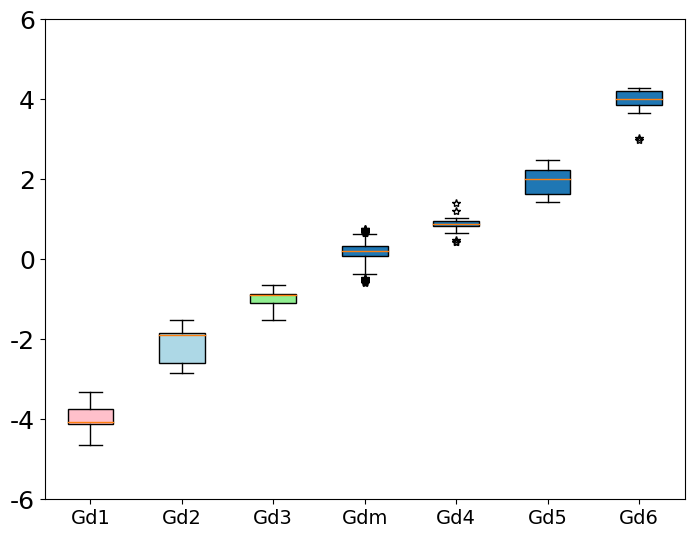

In [9]:
benchmark_path = 'data/FeatureTOF.csv'
type = 'TOF'
df1 = pd.read_csv(benchmark_path)
plot_boxplot(df1, name='TOF', type='TOF', precision=0, lim=6,n='Fold change')

### TOF-benchmark feature table

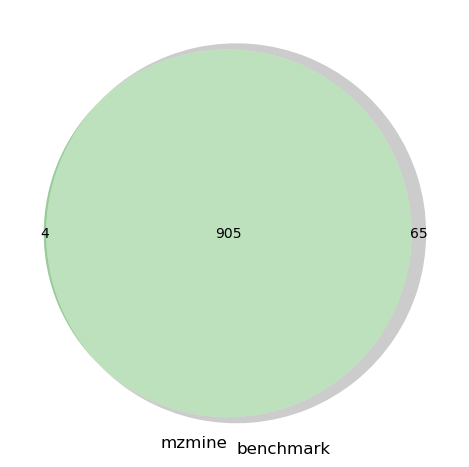

TOF+10.3
precise quantify:745
count:905
precsion:0.8232044198895028
0.878


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


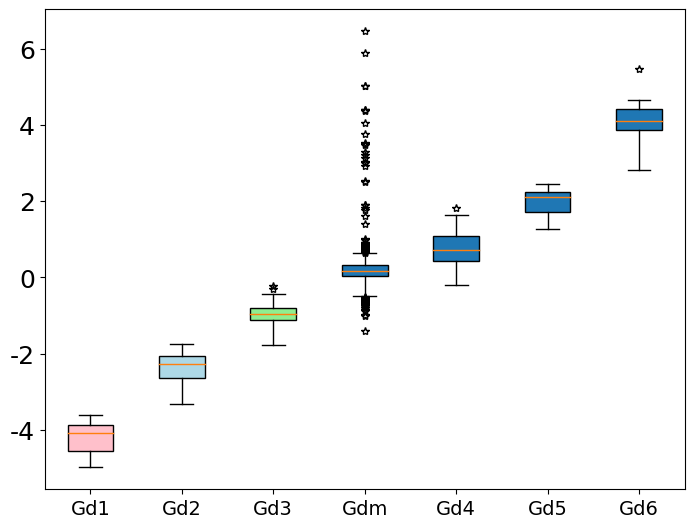

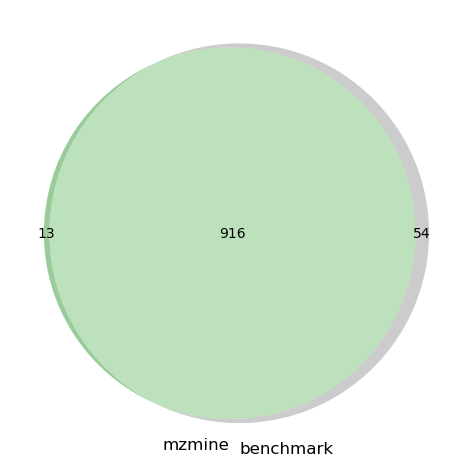

TOF+15.4
precise quantify:797
count:916
precsion:0.8700873362445415
0.907


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


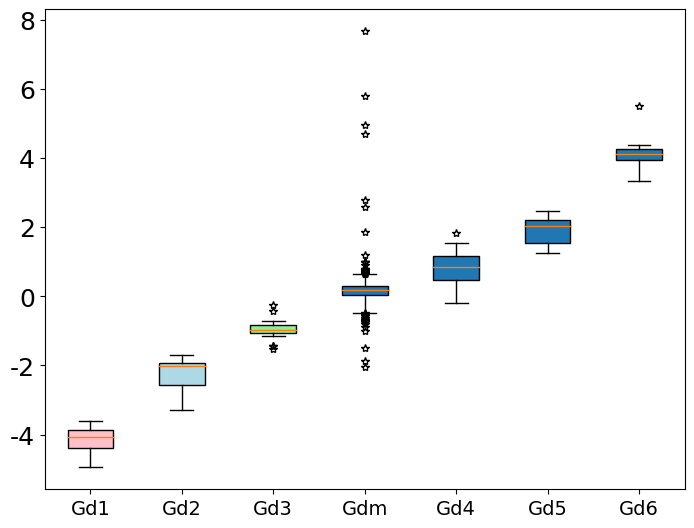

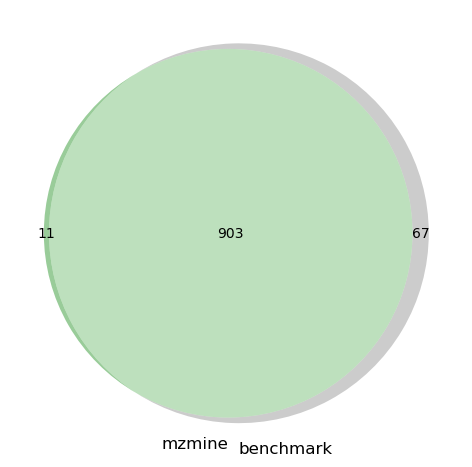

TOF+5.7
precise quantify:712
count:903
precsion:0.7884828349944629
0.86


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


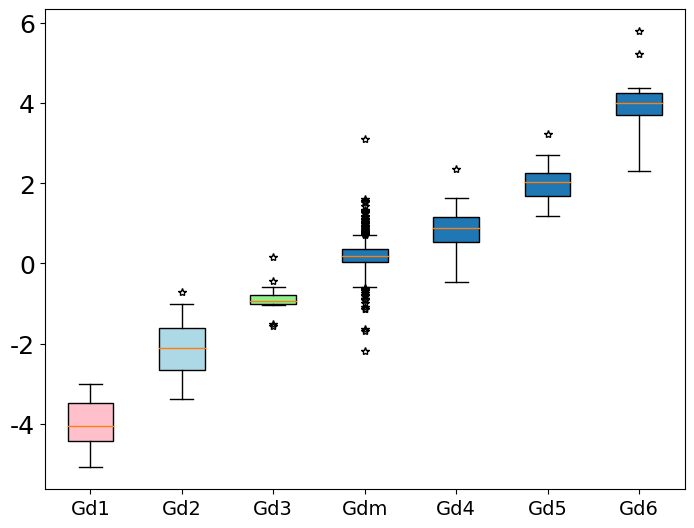

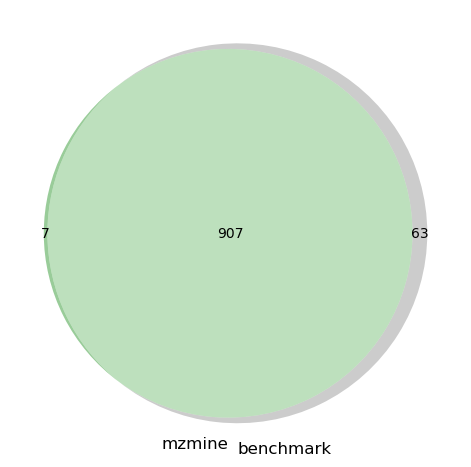

TOF+15.3
precise quantify:742
count:907
precsion:0.8180815876515987
0.877


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


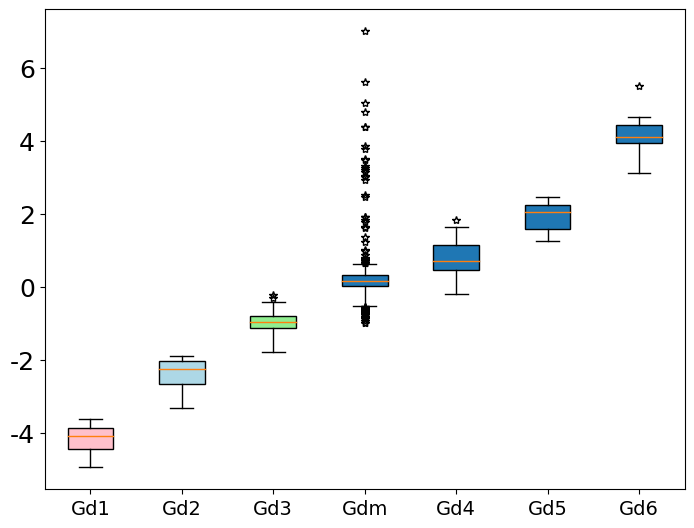

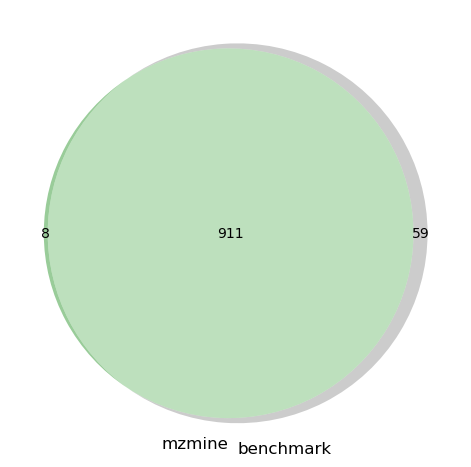

TOF+10.6
precise quantify:792
count:911
precsion:0.8693743139407245
0.904


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


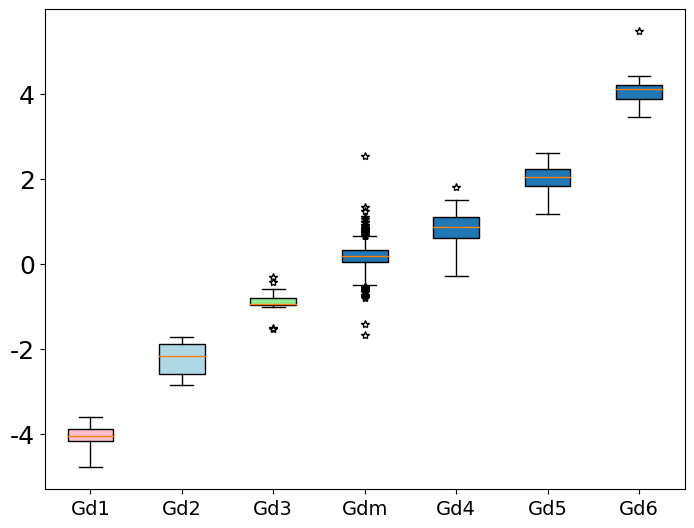

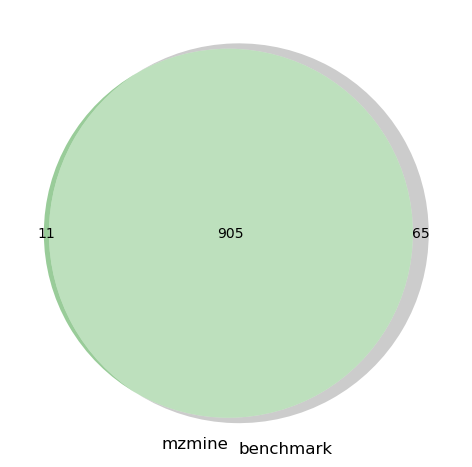

TOF+5.6
precise quantify:704
count:905
precsion:0.7779005524861878
0.855


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


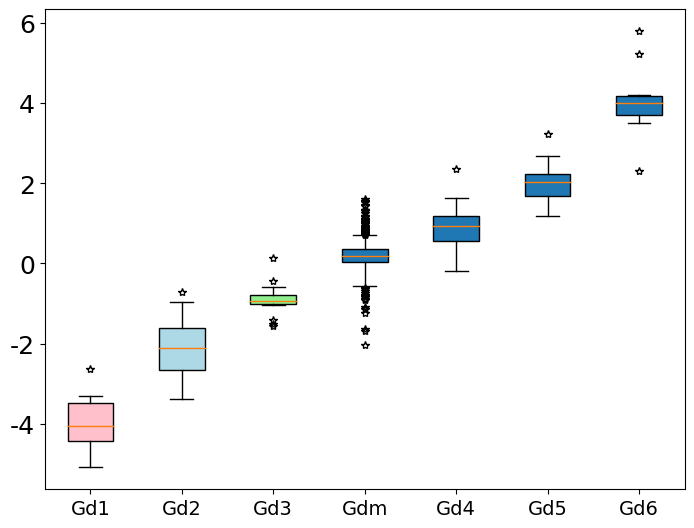

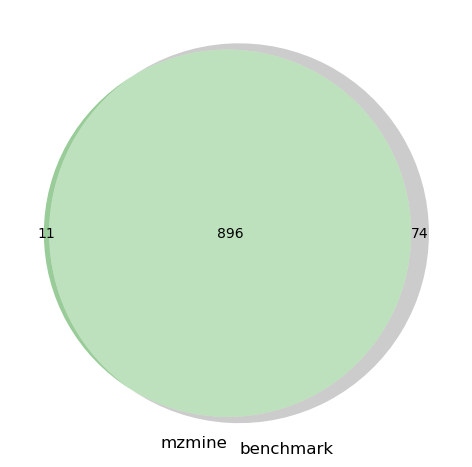

TOF+5.3
precise quantify:660
count:896
precsion:0.7366071428571429
0.83


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


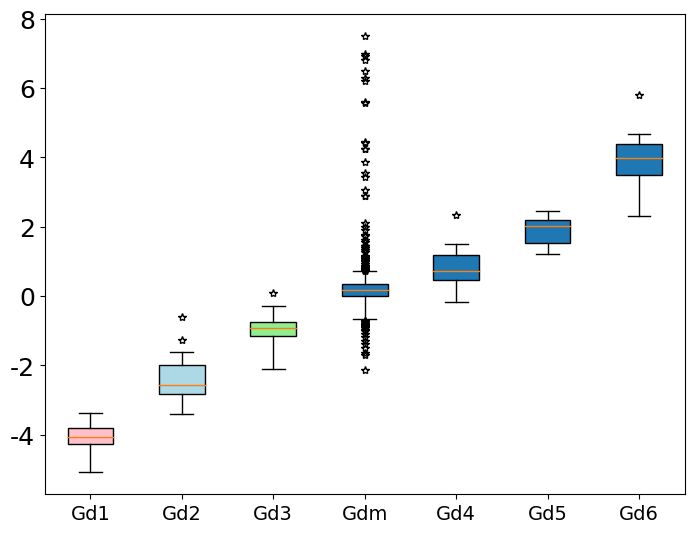

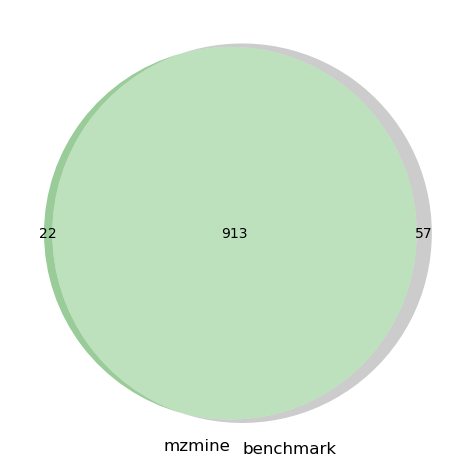

TOF+15.6
precise quantify:805
count:913
precsion:0.8817086527929902
0.911


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


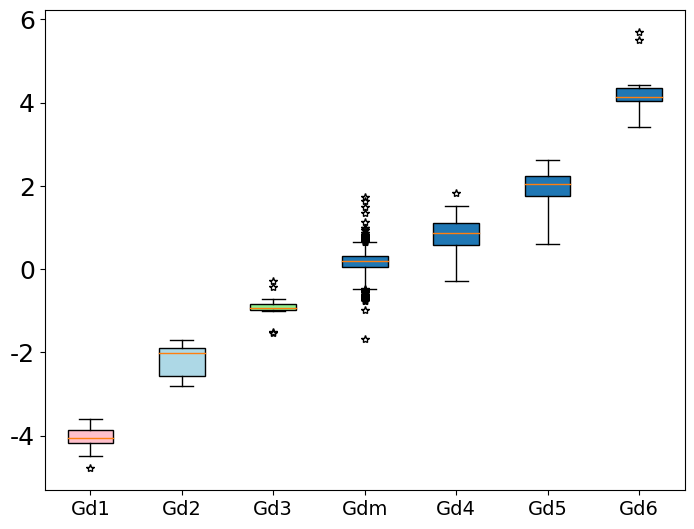

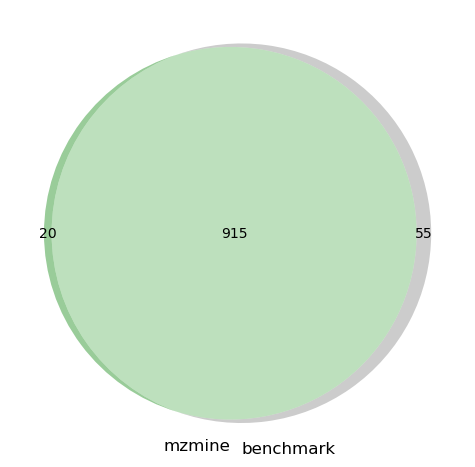

TOF+15.5
precise quantify:799
count:915
precsion:0.8732240437158469
0.908


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


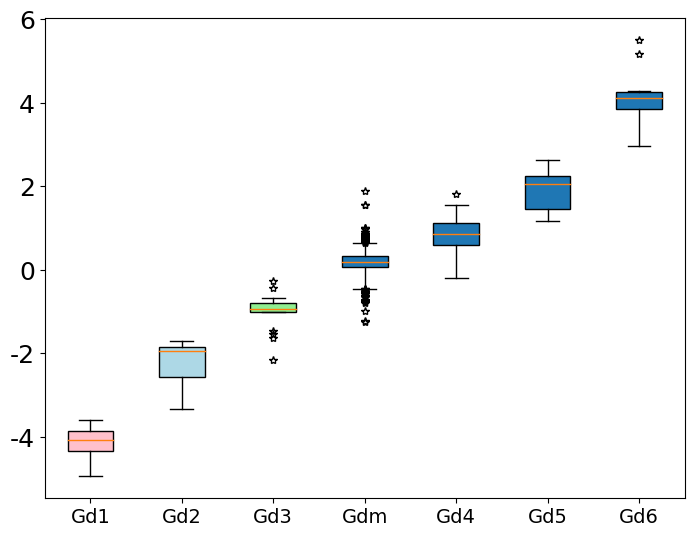

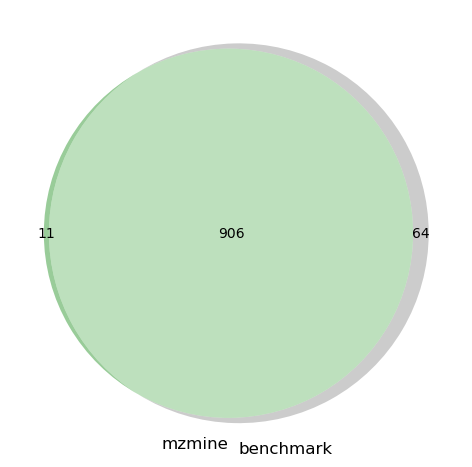

TOF+5.5
precise quantify:699
count:906
precsion:0.7715231788079471
0.853


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


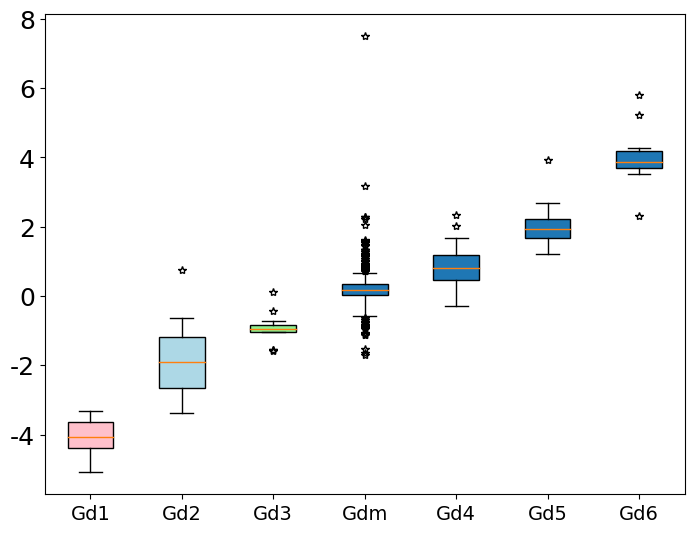

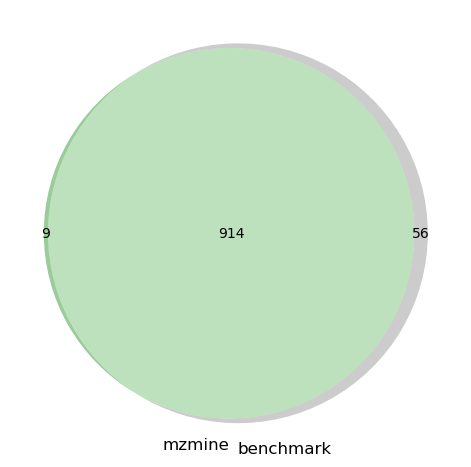

TOF+10.5
precise quantify:796
count:914
precsion:0.8708971553610503
0.907


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


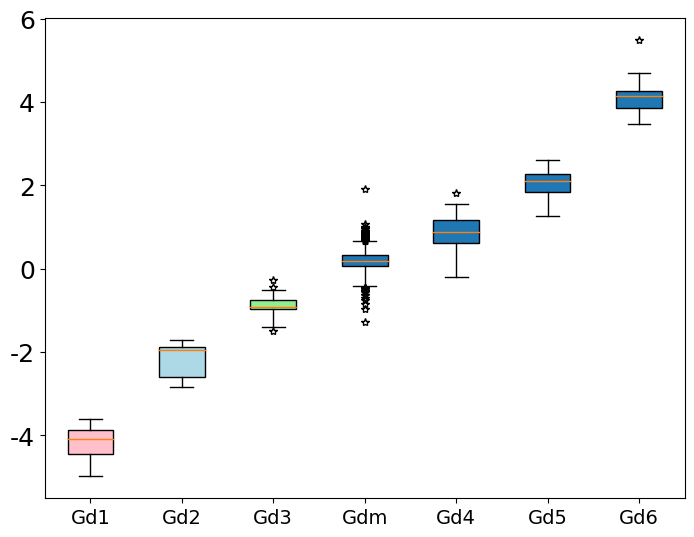

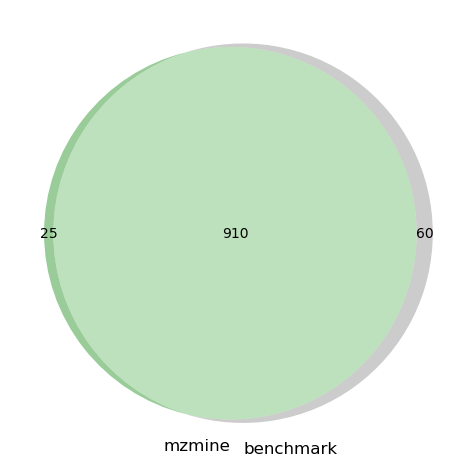

TOF+15.7
precise quantify:806
count:910
precsion:0.8857142857142857
0.912


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


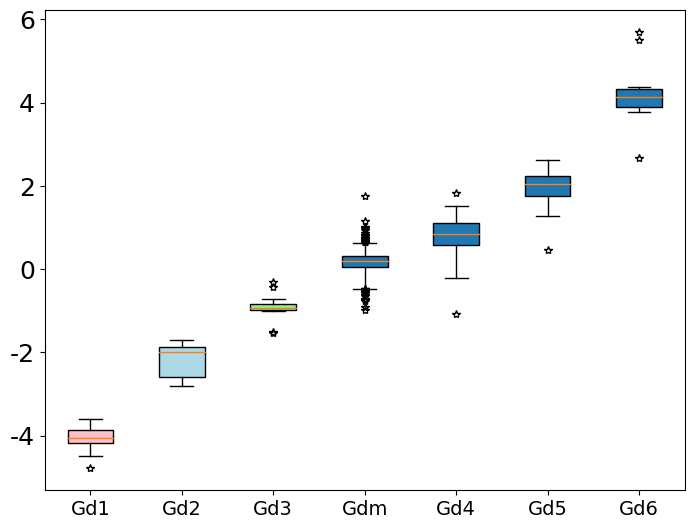

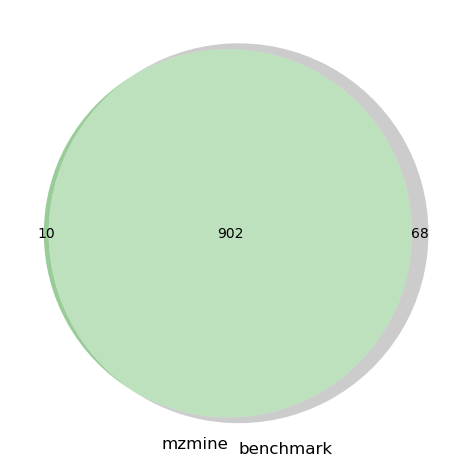

TOF+5.4
precise quantify:703
count:902
precsion:0.779379157427938
0.855


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


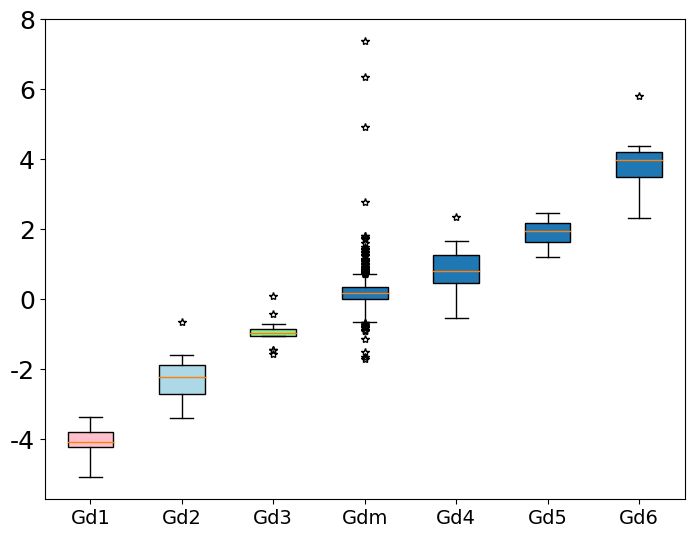

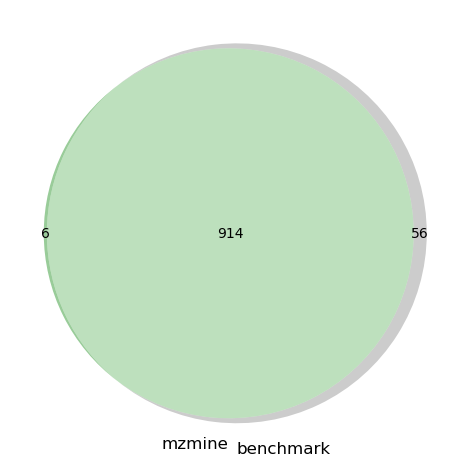

TOF+10.4
precise quantify:787
count:914
precsion:0.8610503282275711
0.902


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


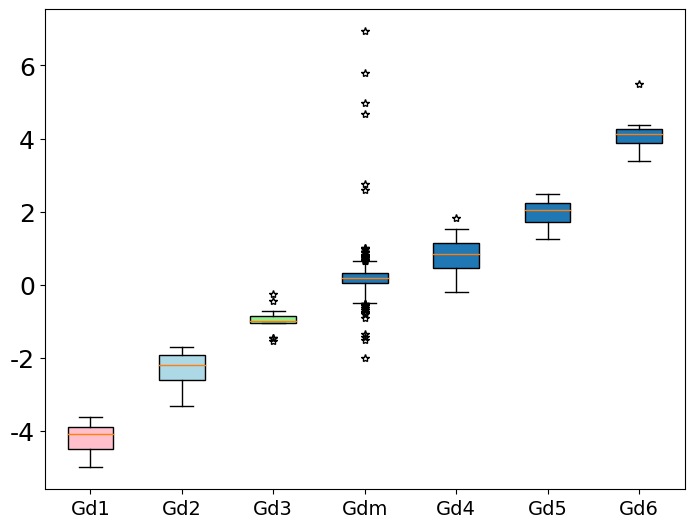

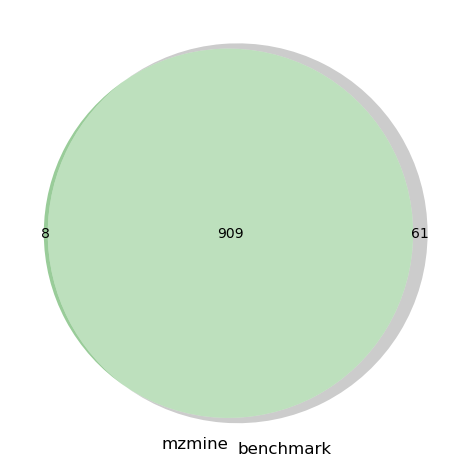

TOF+10.7
precise quantify:794
count:909
precsion:0.8734873487348734
0.905


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


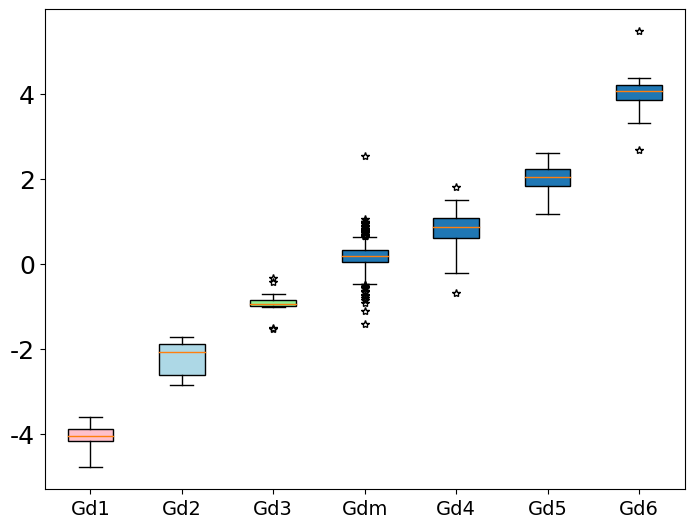

In [10]:
mzmine_dir = 'data/MZMINE3/TOF-raw'
benchmark_path = 'data/FeatureTOF.csv'
type = 'TOF'
boxplot(mzmine_dir, benchmark_path, type)

### The best is 15.7, which means ppm=15, rt_tolerance = 0.7

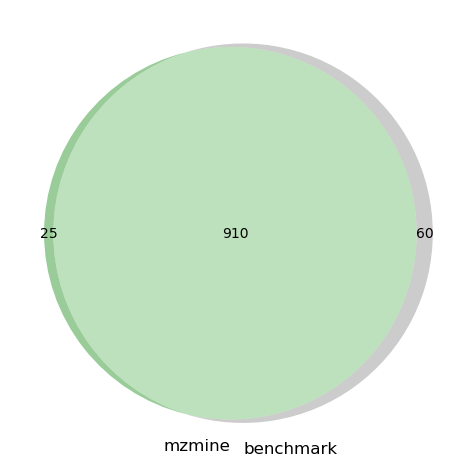

TOF+15.7
precise quantify:806
count:910
precsion:0.8857142857142857
0.912


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


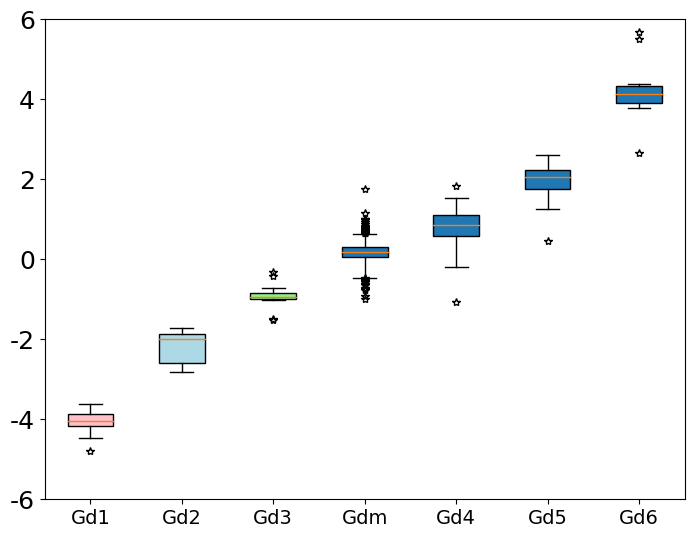

In [11]:
mzmine_path = 'data/MZMINE3/TOF-raw/Aligned_feature_list_gap-filled-15-0.7.csv'
def plot_best(mzmine_path, benchmark_path, type):
    df1, df2 = filter_data(mzmine_path, benchmark_path, type)
    match = re.search(r'-(\d+)-(\d+\.\d+)', mzmine_path)
    if match:
        number1 = int(match.group(1)) 
        number2 = float(match.group(2)) 
        df1, df2 = find_couple(df1, df2, number1, number2)
        plot_venn(df1, df2, type, name=number1 + number2)
        plot_log(df1, type, name=number1 + number2, lim=6, save=True)
plot_best(mzmine_path, benchmark_path, type)

### TOF- feature table with RT drift

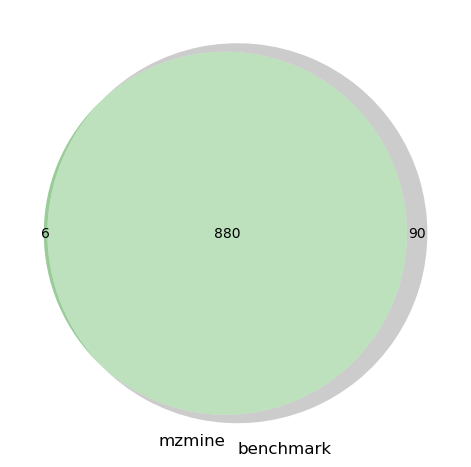

TOFShift+10.3
precise quantify:612
count:880
precsion:0.6954545454545454
0.801


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


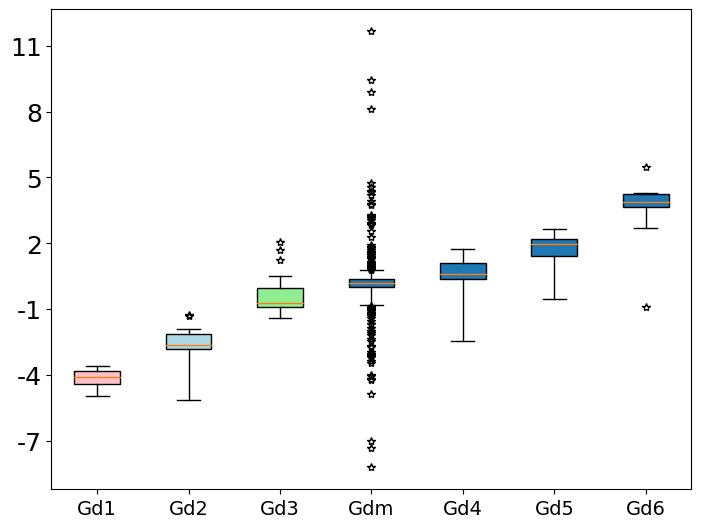

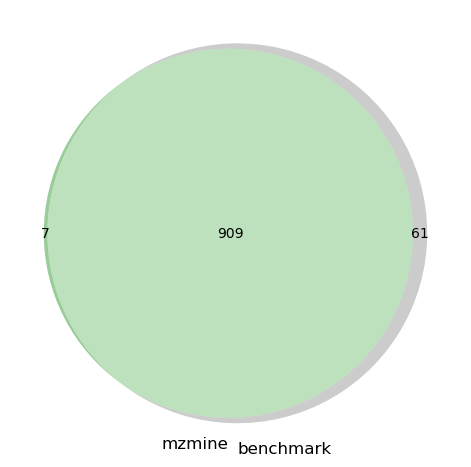

TOFShift+15.4
precise quantify:673
count:909
precsion:0.7403740374037404
0.839


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


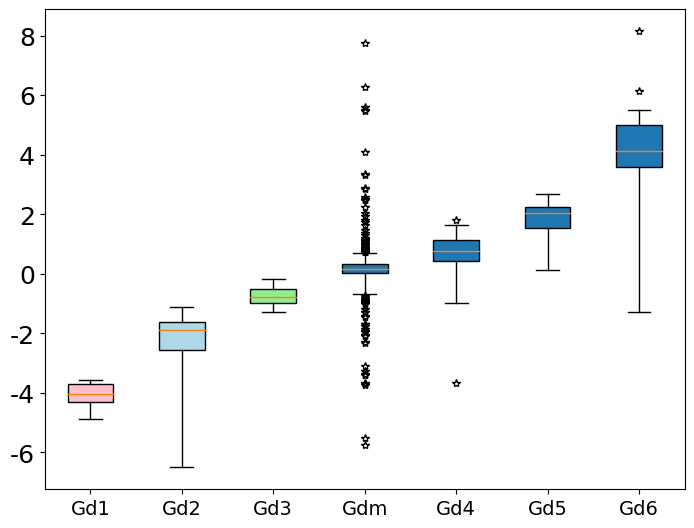

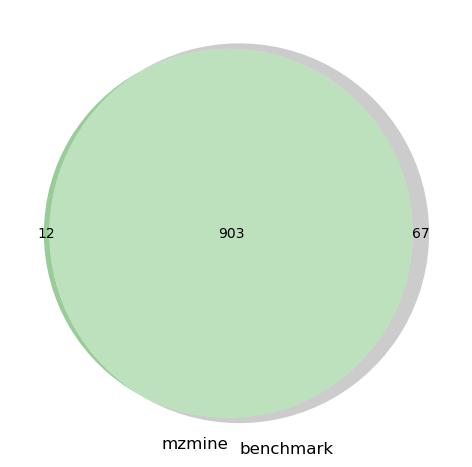

TOFShift+5.7
precise quantify:655
count:903
precsion:0.7253599114064231
0.828


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


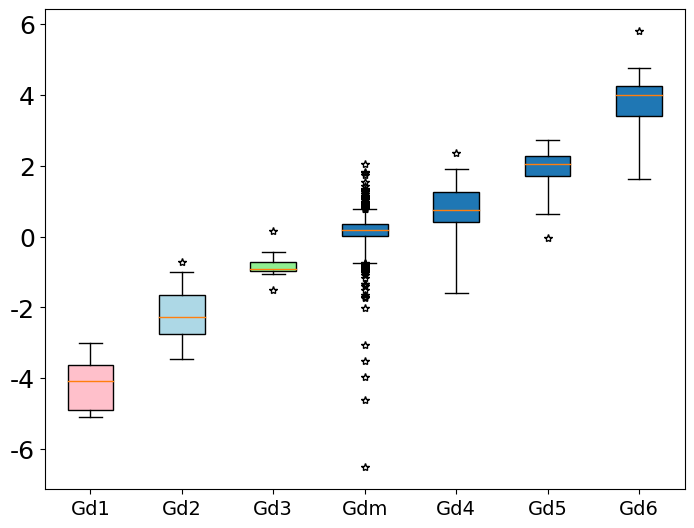

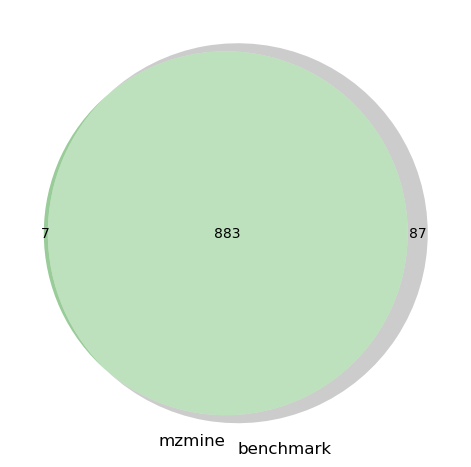

TOFShift+15.3
precise quantify:615
count:883
precsion:0.6964892412231031
0.803


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


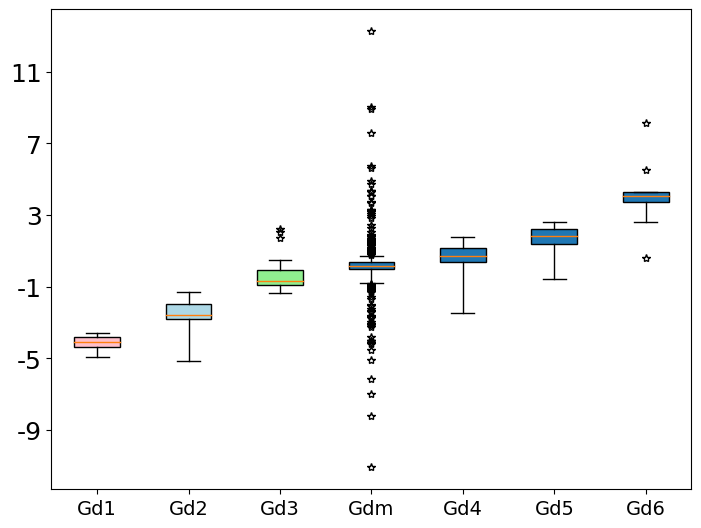

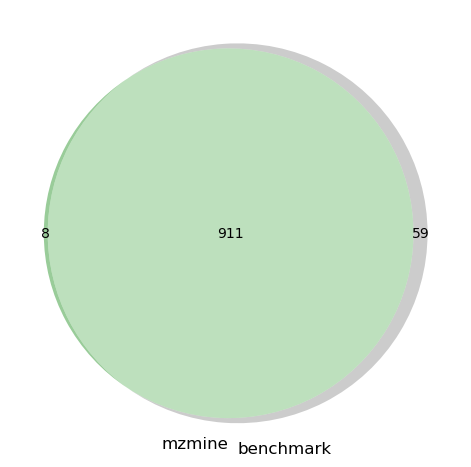

TOFShift+10.6
precise quantify:686
count:911
precsion:0.7530186608122942
0.846


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


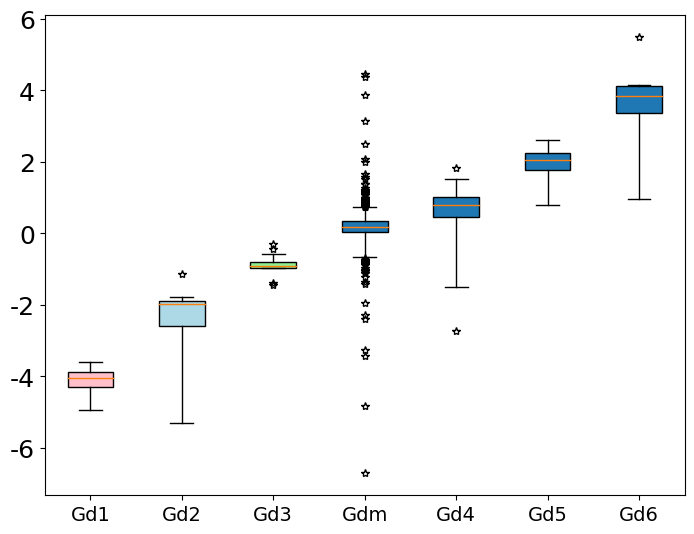

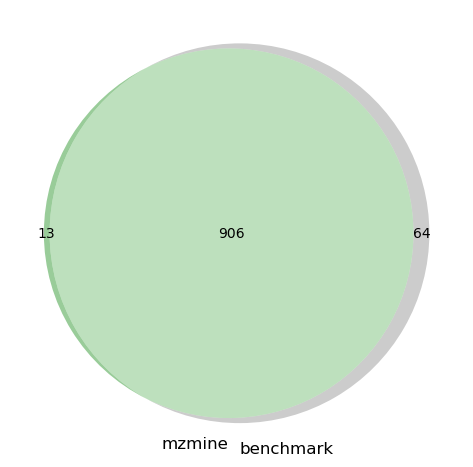

TOFShift+5.6
precise quantify:651
count:906
precsion:0.7185430463576159
0.826


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


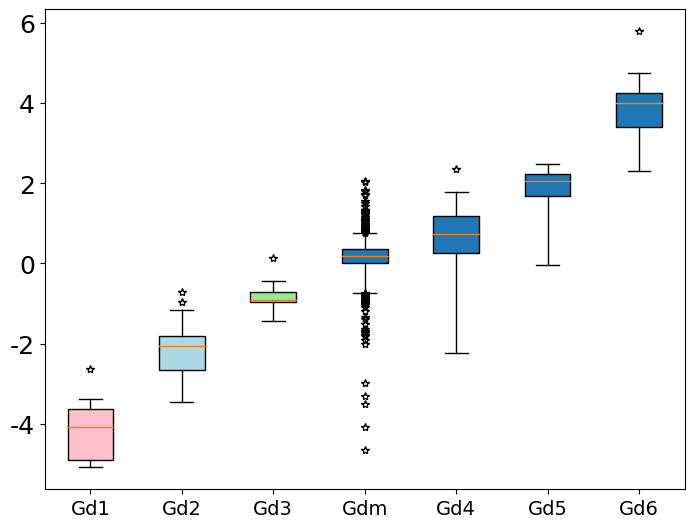

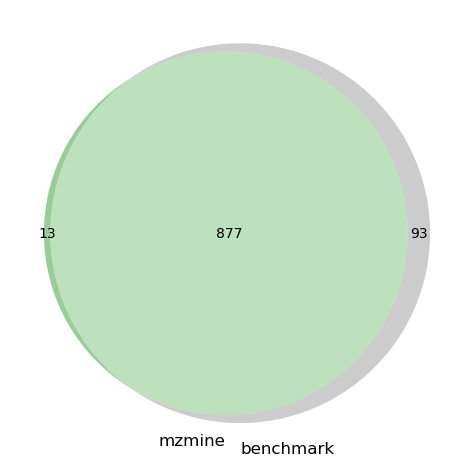

TOFShift+5.3
precise quantify:561
count:877
precsion:0.6396807297605474
0.772


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


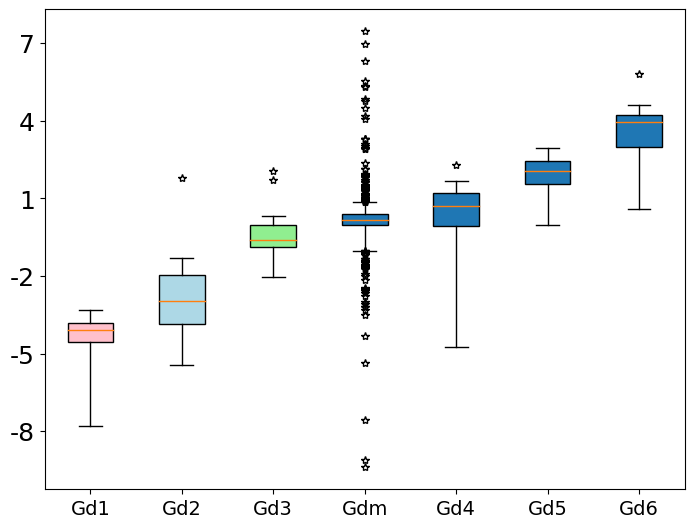

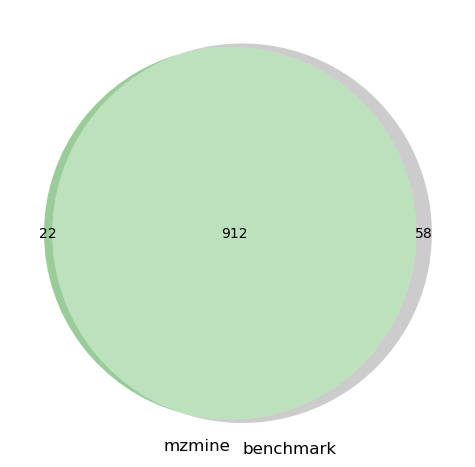

TOFShift+15.6
precise quantify:690
count:912
precsion:0.756578947368421
0.848


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


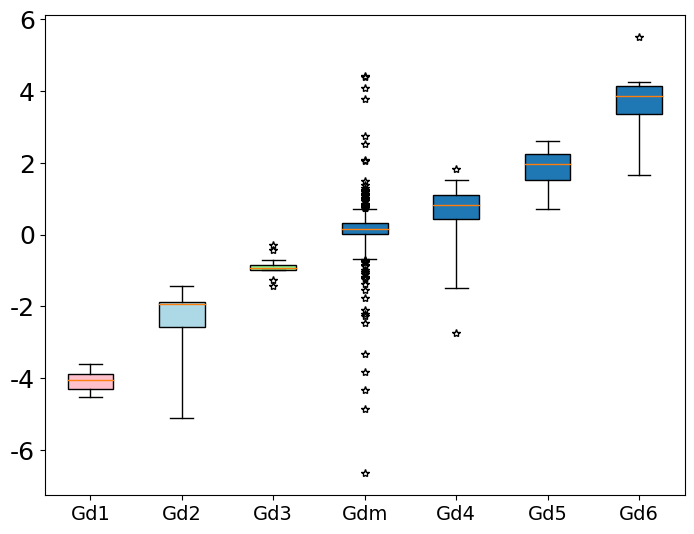

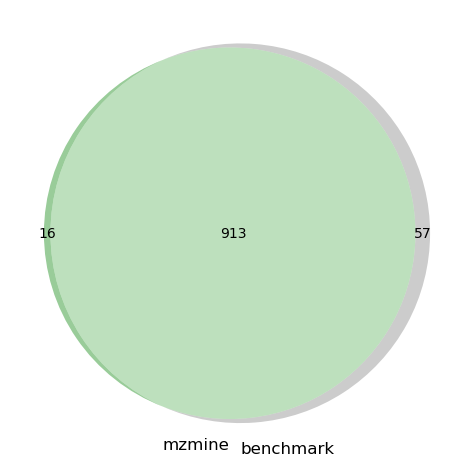

TOFShift+15.5
precise quantify:679
count:913
precsion:0.7437020810514786
0.842


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


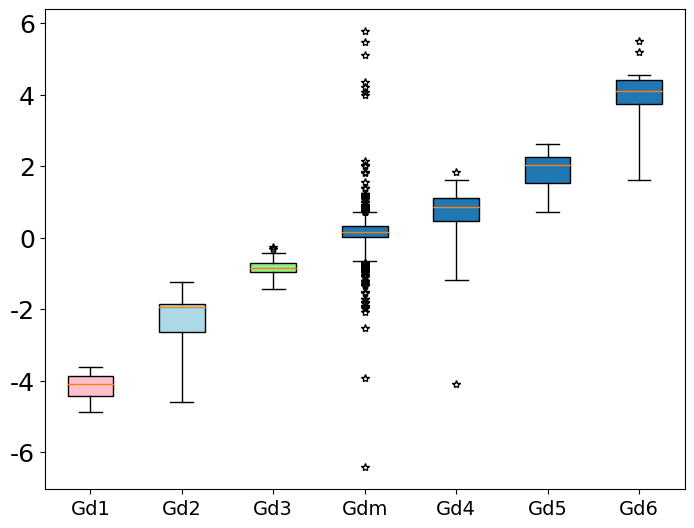

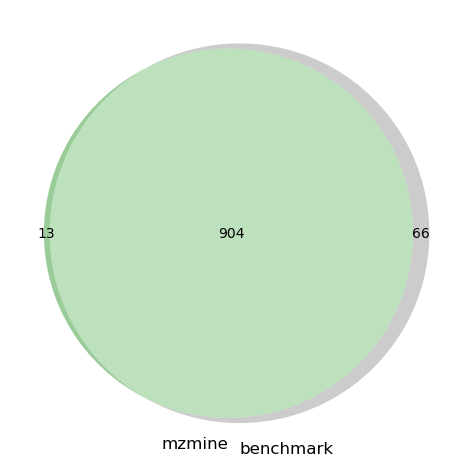

TOFShift+5.5
precise quantify:643
count:904
precsion:0.7112831858407079
0.822


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


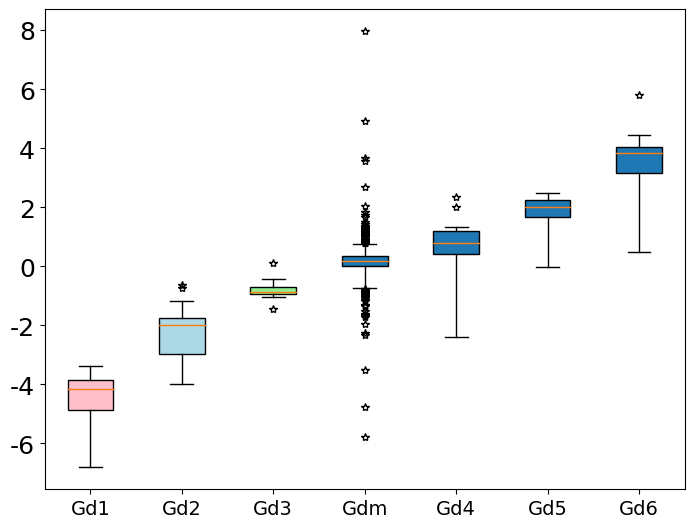

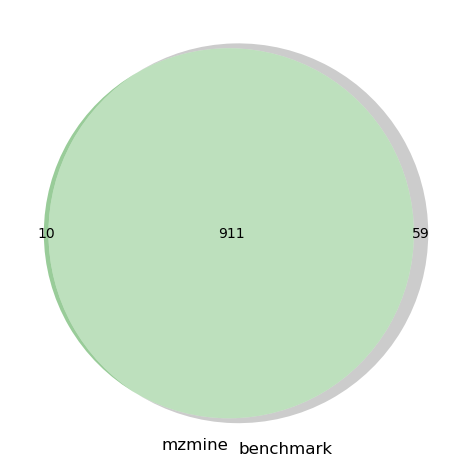

TOFShift+10.5
precise quantify:684
count:911
precsion:0.7508232711306256
0.845


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


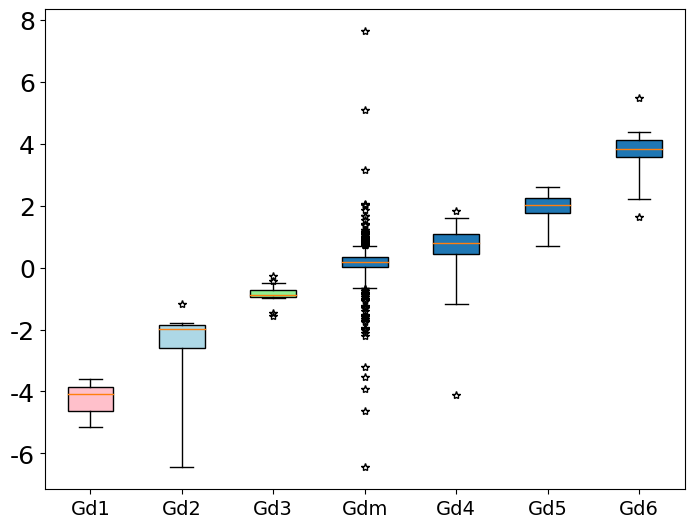

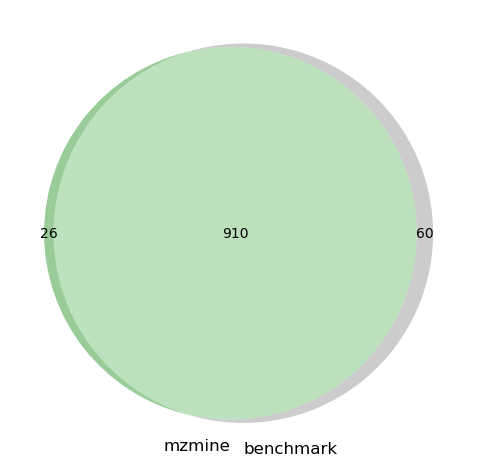

TOFShift+15.7
precise quantify:699
count:910
precsion:0.7681318681318682
0.853


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


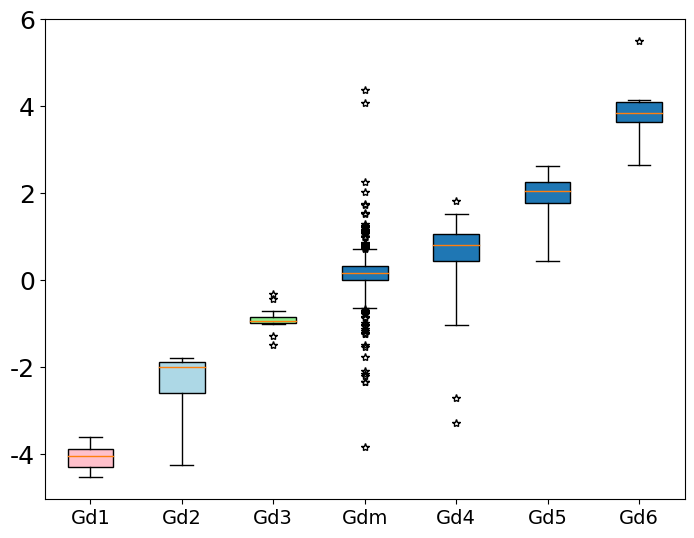

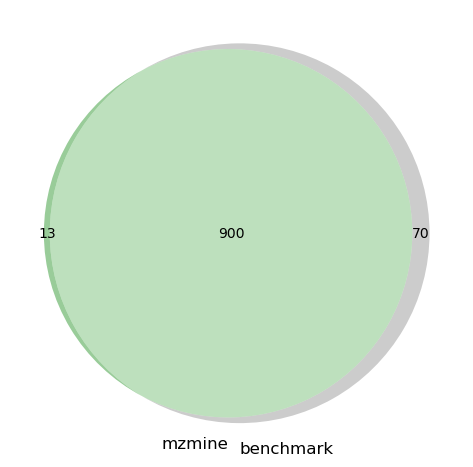

TOFShift+5.4
precise quantify:614
count:900
precsion:0.6822222222222222
0.805


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


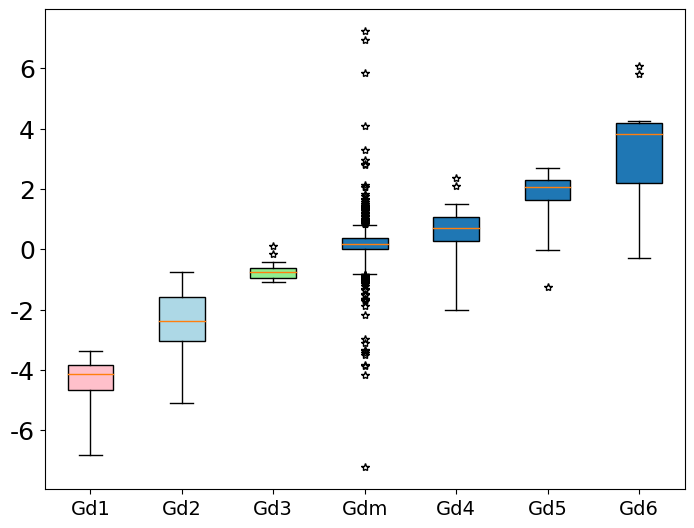

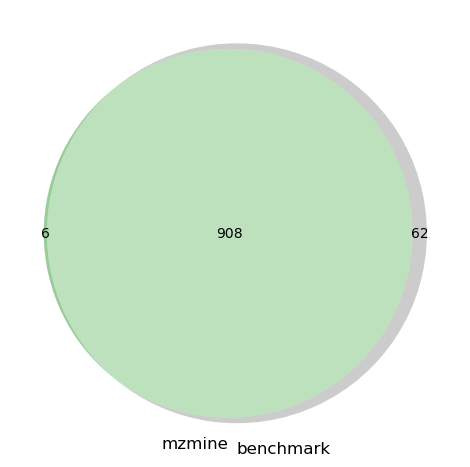

TOFShift+10.4
precise quantify:680
count:908
precsion:0.748898678414097
0.842


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


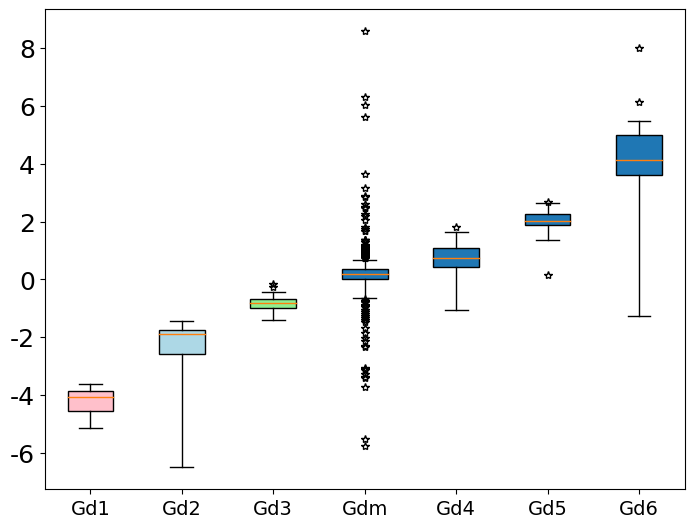

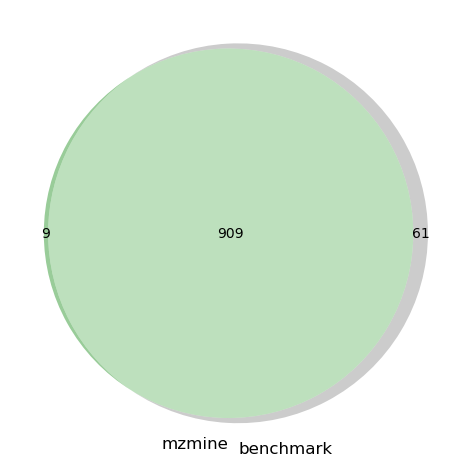

TOFShift+10.7
precise quantify:686
count:909
precsion:0.7546754675467546
0.846


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


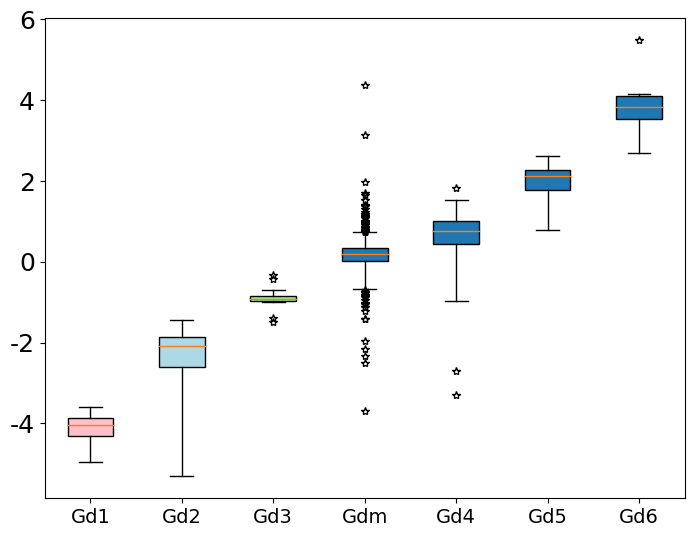

In [12]:
mzmine_dir = 'data/MZMINE3/TOFShift-raw'
benchmark_path = 'data/FeatureTOFShift.csv'
type = 'TOFShift'
boxplot(mzmine_dir, benchmark_path, type)

### The best is 15.7, which means ppm=15, rt_tolerance = 0.7

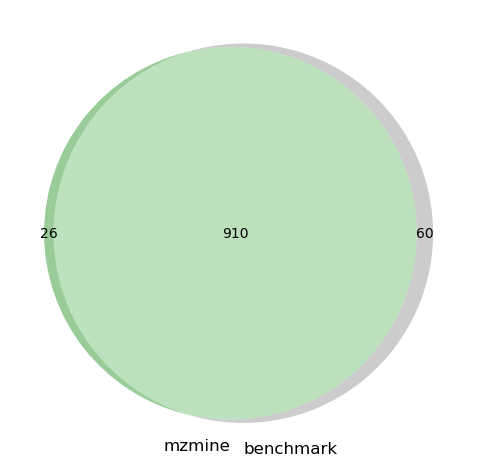

TOFShift+15.7
precise quantify:699
count:910
precsion:0.7681318681318682
0.853


/home/zzy/miniconda3/envs/pytorch38/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_22219/2932776758.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/2932776758.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/2932776758.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


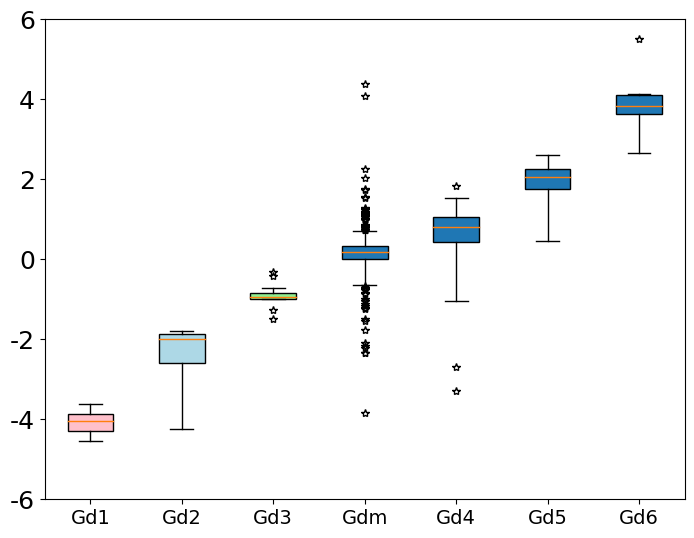

In [13]:
mzmine_path = 'data/MZMINE3/TOFShift-raw/Aligned_feature_list_gap-filled-15-0.7.csv'
def plot_best(mzmine_path, benchmark_path, type):
    df1, df2 = filter_data(mzmine_path, benchmark_path, type)
    match = re.search(r'-(\d+)-(\d+\.\d+)', mzmine_path)
    if match:
        number1 = int(match.group(1)) 
        number2 = float(match.group(2)) 
        df1, df2 = find_couple(df1, df2, number1, number2)
        plot_venn(df1, df2, type, name=number1 + number2)
        plot_log(df1, type, name=number1 + number2, lim=6, save=True)
plot_best(mzmine_path, benchmark_path, type)

## PeakDetective

In [14]:
import os
import re

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn2


def filter_data(SA_path, SB_path, benchmark_path):
    df_SA = pd.read_csv(SA_path)
    df_SB = pd.read_csv(SB_path)

    df_SB_last_five = df_SB.iloc[:, -5:]

    merged_df = pd.concat([df_SA, df_SB_last_five], axis=1)

    df_benchmark = pd.read_csv(benchmark_path)
    df_clean = merged_df[(merged_df != 0).all(axis=1)]  
    df_cleaned = df_clean[df_clean.notnull().all(axis=1)]  
    return df_cleaned, df_benchmark


def find_couple(df_cleaned, df_benchmark):
    df_cleaned.rename(columns={df_cleaned.columns[0]: 'Compound Name'}, inplace=True)
    df_cleaned = pd.merge(df_cleaned, df_benchmark, on=['Compound Name'], how='inner')

    return df_cleaned, df_benchmark


def plot_venn(df1, df2, type, name):
    set1 = set(df1['Compound Name'])
    set2 = set(df2['Compound Name'])
    venn2([set1, set2],
          set_labels=["mzmine", "benchmark"], set_colors=["green", "grey"])
    plt.tight_layout()
    # plt.savefig(f'peakdetective{type}+{name}' + "venn.png", dpi=300)
    plt.show()
    # plt.close()



def plot_boxplot(df, name, precision, lim, n='fc'):
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    graph = ax.boxplot(
        [
            df[df["Compound concentration ratio"] == "1/16"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/4"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/2"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "2/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "4/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "16/1"].loc[:, n],
        ],
        vert=True,
        patch_artist=True,
        labels=["Gd1", "Gd2", "Gd3", "Gdm", "Gd4", "Gd5", "Gd6"],
        sym='*'
    )

    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(graph['boxes'], colors):
        patch.set_facecolor(color)
    plt.tight_layout()

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    plt.yscale('log', base=2)
    import numpy as np
    if lim != 0:
        plt.ylim(1 / 2 ** lim,  2 ** lim)
    ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    # plt.savefig(f"peakdetective{name}+{precision}.png", dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()



def compute_average_and_cv(group_name, column_names, df):

    try:
        group_columns = [f'{column_name}' for column_name in column_names]

        relevant_data = df.select_dtypes(include='number')[group_columns]

        avg = relevant_data.mean(axis=1)
        std = relevant_data.std(axis=1)

        cv = std.where(std != 0, 0) / avg * 100

        return {'AVG': avg, 'CV': cv}
    except Exception as e:
        print(f"Error processing group {group_name}: {e}")
        return {}


def plot_log(df1, type, name,lim,save=False):
    df1 = df1[df1.notnull().all(axis=1)]  
    all_columns = df1.columns.tolist()
    if type == 'TOF' or type == 'TOFShift':
        sample_a_columns = all_columns[3:7]
        sample_b_columns = all_columns[8:12]
    elif type == 'QE' or type == 'QEShift':
        sample_a_columns = all_columns[3:8]
        sample_b_columns = all_columns[8:13]

    sample_a_results = compute_average_and_cv('SampleA', sample_a_columns, df1)
    sample_b_results = compute_average_and_cv('SampleB', sample_b_columns, df1)

    df1.loc[:, 'AVG-A'] = sample_a_results['AVG']
    df1.loc[:, 'CV-A'] = sample_a_results['CV']
    df1.loc[:, 'AVG-B'] = sample_b_results['AVG']
    df1.loc[:, 'CV-B'] = sample_b_results['CV']

    df1.loc[:, 'fc'] = df1.loc[:, 'AVG-B'] / df1.loc[:, 'AVG-A']
    df1.loc[:, 'ratio'] = df1.loc[:, 'fc'] / df1.loc[:, 'Fold change']

    df1 = df1.sort_values(by='Compound Name')
    duplicate_rows = df1[df1.duplicated(subset=['Compound Name'], keep=False)]
    from itertools import groupby
    grouped = [(key, list(group)) for key, group in
                groupby(duplicate_rows.index, key=lambda x: duplicate_rows.loc[x, duplicate_rows.columns[-9]])]

    other_numbers_in_group = []
    # duplicate_rows['abs_'] = abs(duplicate_rows['ratio'] - 1)
    for key, group in grouped:
        min_id = min(group, key=lambda x: (abs(duplicate_rows.loc[x, 'rt'] - duplicate_rows.loc[x, 'True RT'])))

        for id in group:
            if id != min_id:
                other_numbers_in_group.append(id)

    df1.drop(other_numbers_in_group, inplace=True)

    score = calculate_precision(df1, name, type)
    print(score)
    plot_boxplot(df1, name, score, lim)
    if save:
        df1.to_csv(f'peakdetective_{type}.csv', index=False)


def calculate_precision(df, name, type):
    print(f'{type}+{name}')
    df_filtered = df[(df['ratio'] > 0.8) & (df['ratio'] < 1.2)]
    count = df_filtered.shape[0]
    # print(f"precise quantify:{count}")
    # print(f"count:{df.shape[0]}",)
    # print(f"precsion:{count/df.shape[0]}")
    if type == 'TOF' or type == 'TOFShift':
        return round((count/df.shape[0] + df.shape[0] / 970)/2, 3)
    elif type == 'QE' or type == 'QEShift':
        return round((count/df.shape[0] + df.shape[0] / 836)/2, 3)

### QE-benchmark feature table

/tmp/ipykernel_22219/1289674019.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/1289674019.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/1289674019.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


QE+SA-qe_5.csv
0.796


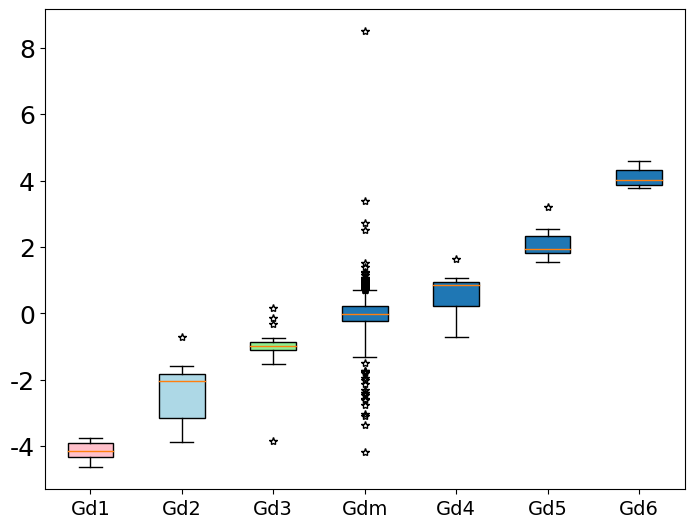

In [15]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/QE/SA-qe_5.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/QE/SB-qe_5.csv'
    benchmark_path = 'data/FeatureQE.csv'
    type = 'QE'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    plot_log(df1, type, name= number1,lim=0)

QE+SA-qe_10.csv
0.887


/tmp/ipykernel_22219/1289674019.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/1289674019.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/1289674019.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


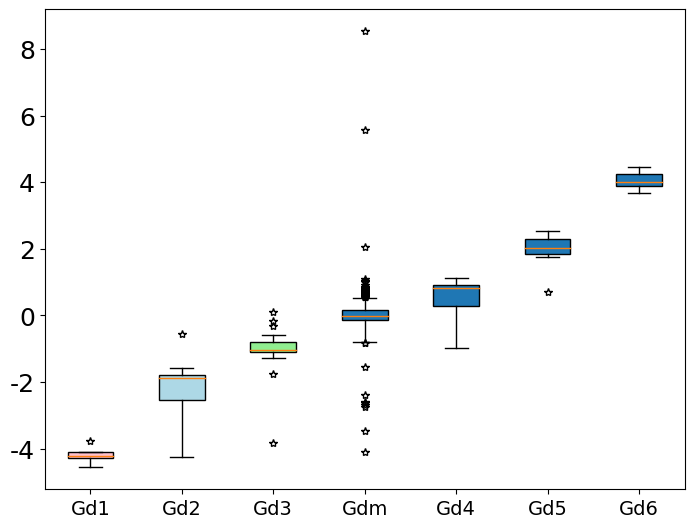

In [16]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/QE/SA-qe_10.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/QE/SB-qe_10.csv'
    benchmark_path = 'data/FeatureQE.csv'
    type = 'QE'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    plot_log(df1, type, name= number1,lim=0)

QE+SA-qe_15.csv
0.911


/tmp/ipykernel_22219/1289674019.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/1289674019.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/1289674019.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


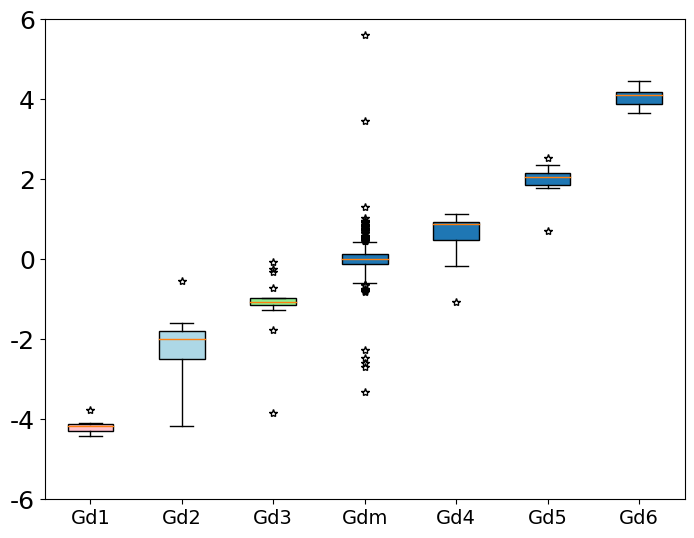

In [17]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/QE/SA-qe_15.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/QE/SB-qe_15.csv'
    benchmark_path = 'data/FeatureQE.csv'
    type = 'QE'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    plot_log(df1, type, name= number1,lim=6,save=True)

### QE- feature table with RT drift

(770, 13)
(770, 19)
QEShift+SA-qeb_5.csv
0.72


/tmp/ipykernel_22219/1289674019.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/1289674019.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/1289674019.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


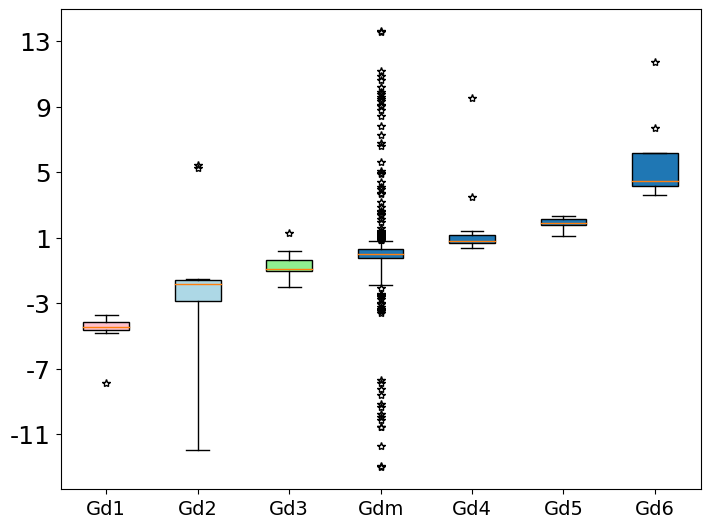

In [18]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/QE/SA-qeb_5.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/QE/SB-qeb_5.csv'
    benchmark_path = 'data/FeatureQEShift.csv'
    type = 'QEShift'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0)

(772, 13)
(772, 19)
QEShift+SA-qeb_10.csv
0.797


/tmp/ipykernel_22219/1289674019.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/1289674019.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/1289674019.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


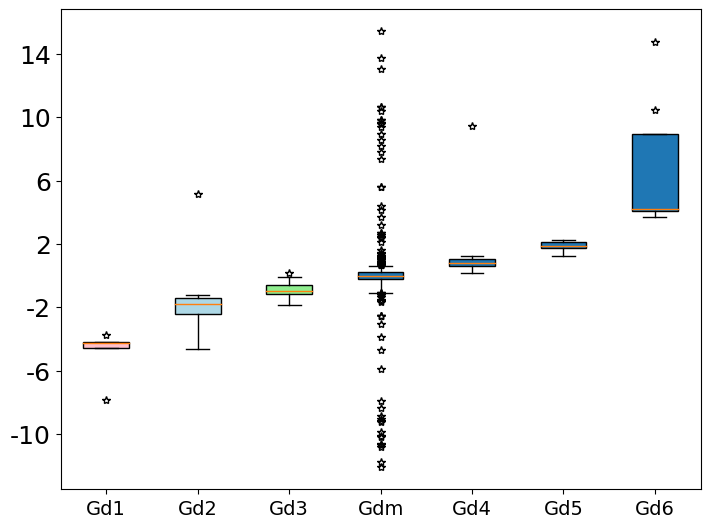

In [19]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/QE/SA-qeb_10.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/QE/SB-qeb_10.csv'
    benchmark_path = 'data/FeatureQEShift.csv'
    type = 'QEShift'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0)

(768, 13)
(768, 19)
QEShift+SA-qeb_15.csv
0.803


/tmp/ipykernel_22219/1289674019.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/1289674019.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/1289674019.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


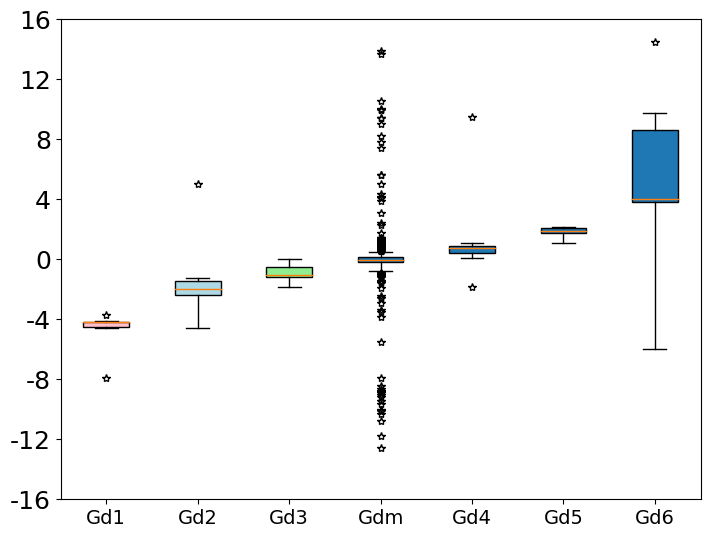

In [20]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/QE/SA-qeb_15.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/QE/SB-qeb_15.csv'
    benchmark_path = 'data/FeatureQEShift.csv'
    type = 'QEShift'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=16,save=True)

### TOF-benchmark feature table

(952, 12)
(952, 18)
TOF+SA-tof_5.csv
0.72


/tmp/ipykernel_22219/1289674019.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/1289674019.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/1289674019.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


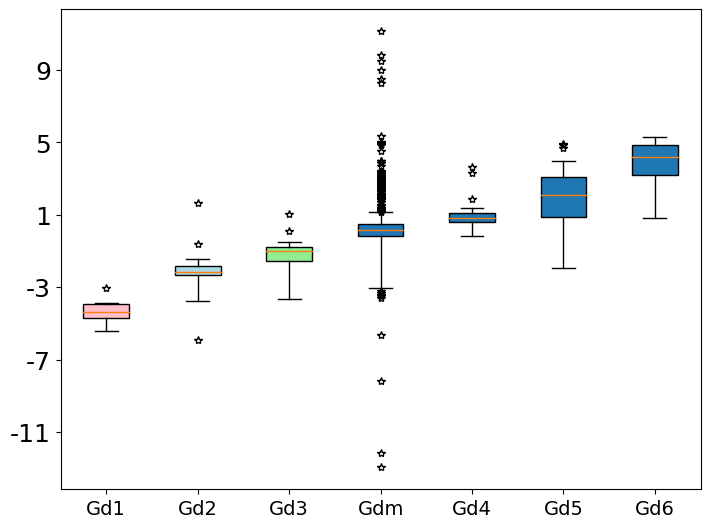

In [21]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/TOF/SA-tof_5.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/TOF/SB-tof_5.csv'
    benchmark_path = 'data/FeatureTOF.csv'
    type = 'TOF'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0)

/tmp/ipykernel_22219/1289674019.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(962, 12)
(962, 18)
TOF+SA-tof_10.csv
0.789


/tmp/ipykernel_22219/1289674019.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/1289674019.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


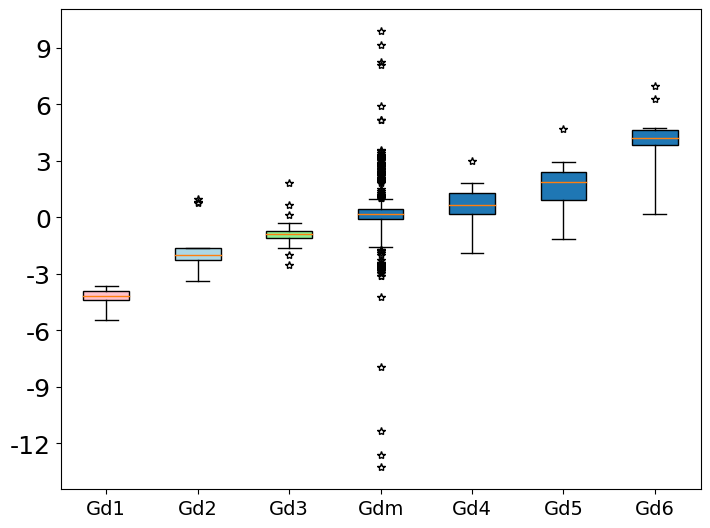

In [22]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/TOF/SA-tof_10.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/TOF/SB-tof_10.csv'
    benchmark_path = 'data/FeatureTOF.csv'
    type = 'TOF'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0)

### The best one

(964, 12)
(964, 18)


/tmp/ipykernel_22219/1289674019.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/1289674019.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)


TOF+SA-tof_15.csv
0.802


/tmp/ipykernel_22219/1289674019.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


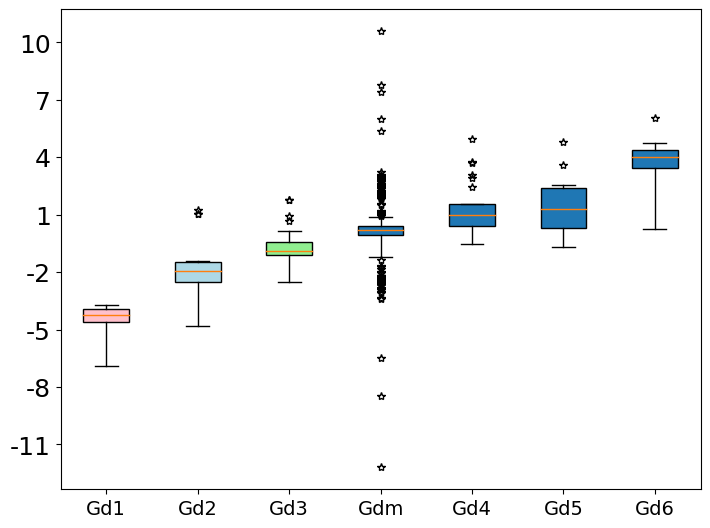

In [23]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/TOF/SA-tof_15.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/TOF/SB-tof_15.csv'
    benchmark_path = 'data/FeatureTOF.csv'
    type = 'TOF'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0,save=True)

### TOF feature table with RT drift

(856, 12)
(856, 18)
TOFShift+SA-tofb_5.csv
0.608


/tmp/ipykernel_22219/1289674019.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/1289674019.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/1289674019.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


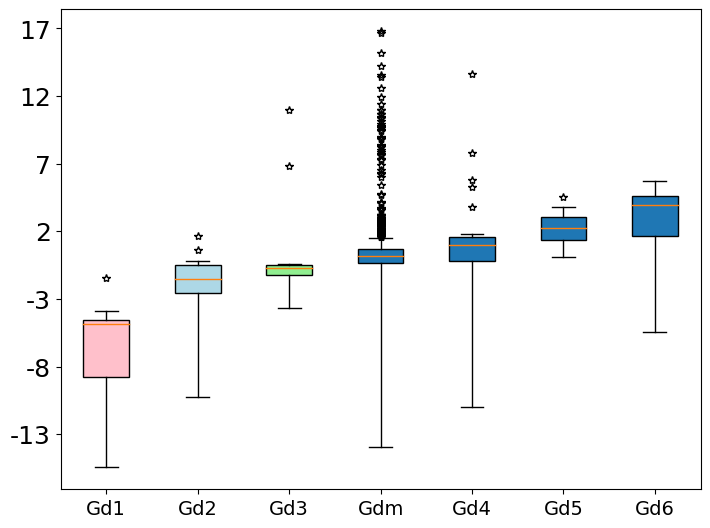

In [24]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/TOF/SA-tofb_5.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/TOF/SB-tofb_5.csv'
    benchmark_path = 'data/FeatureTOFShift.csv'
    type = 'TOFShift'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0)

/tmp/ipykernel_22219/1289674019.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(877, 12)
(877, 18)
TOFShift+SA-tofb_10.csv
0.655


/tmp/ipykernel_22219/1289674019.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/1289674019.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


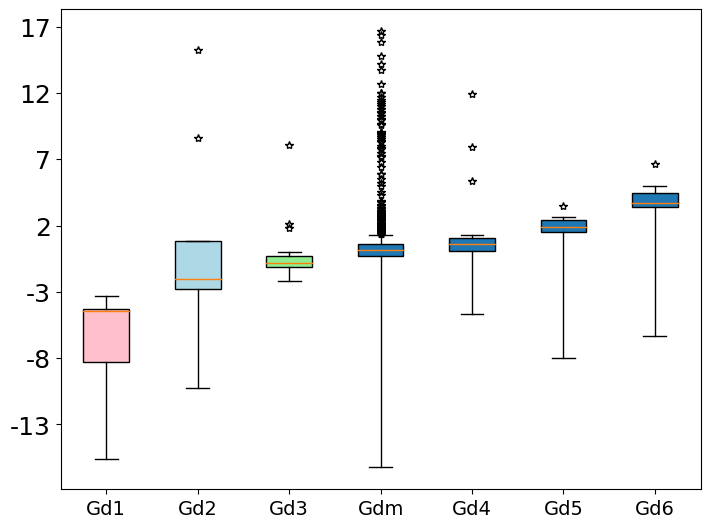

In [25]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/TOF/SA-tofb_10.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/TOF/SB-tofb_10.csv'
    benchmark_path = 'data/FeatureTOFShift.csv'
    type = 'TOFShift'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0)

### The best one.

(893, 12)
(893, 18)


/tmp/ipykernel_22219/1289674019.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/1289674019.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)


TOFShift+SA-tofb_15.csv
0.684


/tmp/ipykernel_22219/1289674019.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


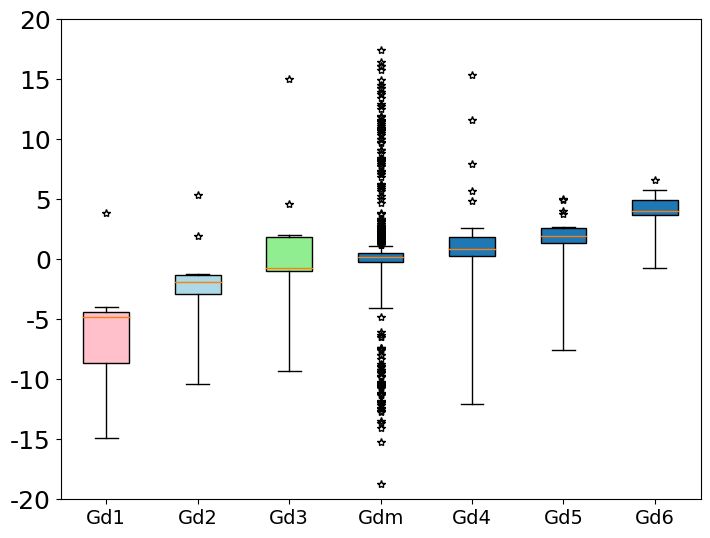

In [26]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/TOF/SA-tofb_15.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/TOF/SB-tofb_15.csv'
    benchmark_path = 'data/FeatureTOFShift.csv'
    type = 'TOFShift'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=20,save=True)

## PeakFormer

In [27]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2


def filter_duplicate(msdetr_path, benchmark_path):
    df_msdetr = pd.read_csv(msdetr_path)
    df_msdetr = df_msdetr[['Image_Path', 'Compound Name', 'Retention Time', 'Area']]
    df_QE = pd.read_csv(benchmark_path)
    merged_df = pd.merge(df_msdetr, df_QE, on='Compound Name')

    grouped = merged_df.groupby('Compound Name')
    num_unique = merged_df['Image_Path'].nunique()

    drop = []
    for a, b in grouped:
        if len(b) > num_unique:
            grouped_ = b.groupby('Image_Path')
            for x, y in grouped_:
                diff = abs(y.iloc[:]['Retention Time'] - y.iloc[:]['RT'])
                min_diff_index = diff.idxmin()
                other_index = diff.index[diff.index != min_diff_index]
                drop.append(other_index)

    indices_to_remove = [item for sublist in [i.tolist() for i in drop if len(i) > 0] for item in sublist]

    single_df = merged_df.drop(indices_to_remove, axis=0)
    return single_df


def post_process(old_df, benchmark_path):
    old_df = old_df[['Image_Path', 'Compound Name', 'Retention Time', 'Area']]

    df_new = old_df.pivot(index='Compound Name', columns='Image_Path', values=['Retention Time', 'Area'])

    df_new.columns = [f'{col[1]}_{col[0]}' for col in df_new.columns]

    df_new.reset_index(inplace=False)

    df_QE = pd.read_csv(benchmark_path)
    merged_df = pd.merge(df_new, df_QE, on='Compound Name')
    return merged_df


def plot_boxplot(df, name, type, precision, n='fc'):
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    graph = ax.boxplot(
        [
            df[df["Compound concentration ratio"] == "1/16"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/4"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/2"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "2/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "4/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "16/1"].loc[:, n],
        ],
        vert=True,
        patch_artist=True,
        labels=["Gd1", "Gd2", "Gd3", "Gdm", "Gd4", "Gd5", "Gd6"],
        sym='*'
    )

    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(graph['boxes'], colors):
        patch.set_facecolor(color)
    plt.tight_layout()

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    plt.yscale('log', base=2)
    import numpy as np
    plt.ylim(1 / 2**6,  2**6)
    ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
#     plt.savefig(f"{type}+{name}+{precision}.png", dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()



def compute_average_and_cv(group_name, column_names, df):

    try:
        group_columns = [f'{column_name}' for column_name in column_names]

        relevant_data = df.select_dtypes(include='number')[group_columns]

        avg = relevant_data.mean(axis=1)
        std = relevant_data.std(axis=1)

        cv = std.where(std != 0, 0) / avg * 100

        return {'AVG': avg, 'CV': cv}
    except Exception as e:
        print(f"Error processing group {group_name}: {e}")
        return {}


def plot_log(df1, type, name, output_path):
    df1 = df1[df1.notnull().all(axis=1)]
    all_columns = df1.columns.tolist()

    if type == 'TOF' or type == 'TOFShift':
        import pandas as pd
        sample_a_columns = [all_columns[i] for i in [-14, -13, -8, -7]]
        sample_b_columns = [all_columns[i] for i in [-12,-11, -10, -9]]
    elif type == 'QE' or type == 'QEShift':
        sample_a_columns = all_columns[-16:-11]
        sample_b_columns = all_columns[-11:-6]

    sample_a_results = compute_average_and_cv('SampleA', sample_a_columns, df1)
    sample_b_results = compute_average_and_cv('SampleB', sample_b_columns, df1)

    df1.loc[:, 'AVG-A'] = sample_a_results['AVG']
    df1.loc[:, 'CV-A'] = sample_a_results['CV']
    df1.loc[:, 'AVG-B'] = sample_b_results['AVG']
    df1.loc[:, 'CV-B'] = sample_b_results['CV']

    df1.loc[:, 'fc'] = df1.loc[:, 'AVG-B'] / df1.loc[:, 'AVG-A']
    df1.loc[:, 'ratio'] = df1.loc[:, 'fc'] / df1.loc[:, 'Fold change']

    df_cleaned = df1[df1.notnull().all(axis=1)]

    precsion = calculate_precision(df_cleaned, name, type)
    plot_boxplot(df_cleaned, name, type, precsion)
    df_cleaned.to_csv(output_path)


def calculate_precision(df, name, type):
    print(f'{type}+{name}')
    df_filtered = df[(df['ratio'] > 0.8) & (df['ratio'] < 1.2)]
    count = df_filtered.shape[0]
    print(f"precise quantify:{count}")
    print(f"count:{df.shape[0]}",)
    print(f"precsion:{count/df.shape[0]}")
    if type == 'TOF' or type == 'TOFShift':
        return round((count/df.shape[0] + df.shape[0] / 970)/2, 3)
    elif type == 'QE' or type == 'QEShift':
        return round((count/df.shape[0] + df.shape[0] / 836)/2, 3)

QE+PeakFormer
precise quantify:805
count:835
precsion:0.9640718562874252


/tmp/ipykernel_22219/3925721420.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/3925721420.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/3925721420.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


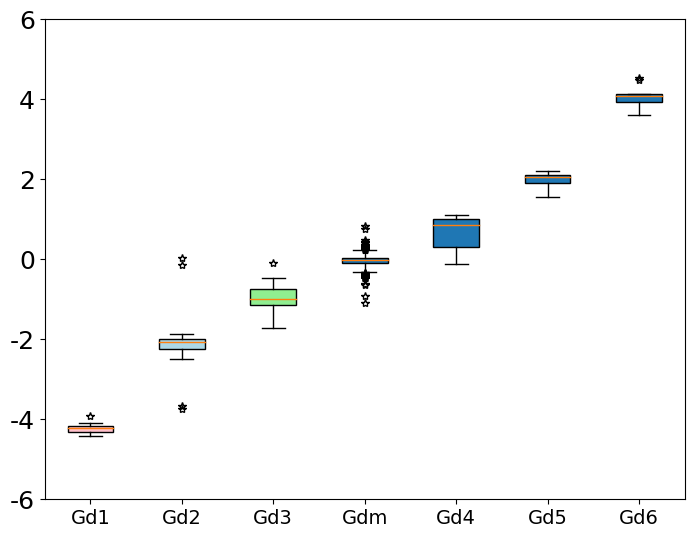

In [30]:
if __name__ == '__main__':
    PeakFormer_path = 'data/Mine/QE/areas.csv'
    benchmark_path = 'data/FeatureQE.csv'
    output_path = 'data/Mine/QE/post-my-qe.csv'
    type = 'QE'
    df = filter_duplicate(PeakFormer_path, benchmark_path)
    df1 = post_process(df, benchmark_path)
    plot_log(df1, type, 'PeakFormer',output_path)

QEShift+PeakFormer
precise quantify:802
count:835
precsion:0.9604790419161676


/tmp/ipykernel_22219/3925721420.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/3925721420.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/3925721420.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


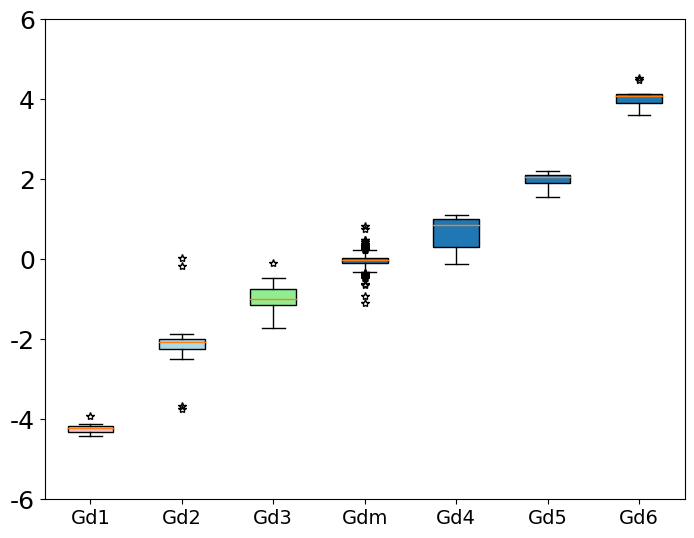

In [31]:
if __name__ == '__main__':
    PeakFormer_path = 'data/Mine/QEShift/areas.csv'
    benchmark_path = 'data/FeatureQEShift.csv'
    output_path = 'data/Mine/QEShift/post-my-qe.csv'
    type = 'QEShift'
    df = filter_duplicate(PeakFormer_path, benchmark_path)
    df1 = post_process(df, benchmark_path)
    plot_log(df1, type, 'PeakFormer', output_path)

TOF+PeakFormer
precise quantify:909
count:970
precsion:0.9371134020618557


/tmp/ipykernel_22219/3925721420.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/3925721420.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/3925721420.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


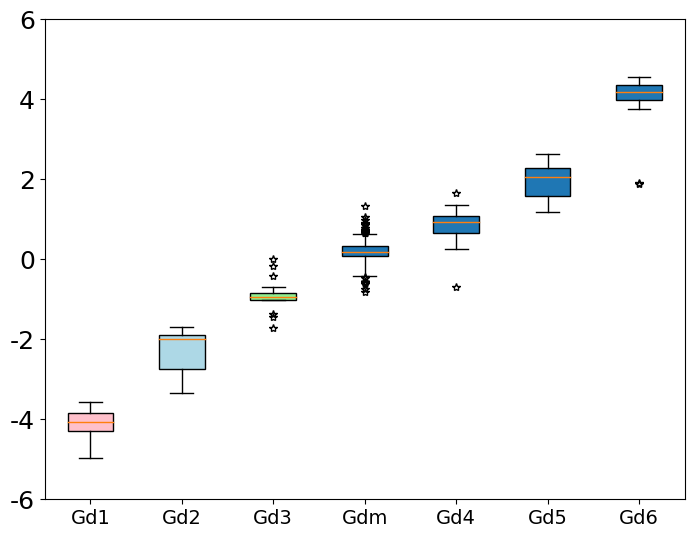

In [32]:
if __name__ == '__main__':
    PeakFormer_path = 'data/Mine/TOF/areas.csv'
    benchmark_path = 'data/FeatureTOF.csv'
    output_path = 'data/Mine/TOF/post-my-tof.csv'
    type = 'TOF'
    df = filter_duplicate(PeakFormer_path, benchmark_path)
    df1 = post_process(df, benchmark_path)
    plot_log(df1, type, 'PeakFormer', output_path)

TOFShift+PeakFormer
precise quantify:904
count:970
precsion:0.931958762886598


/tmp/ipykernel_22219/3925721420.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/3925721420.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
/tmp/ipykernel_22219/3925721420.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


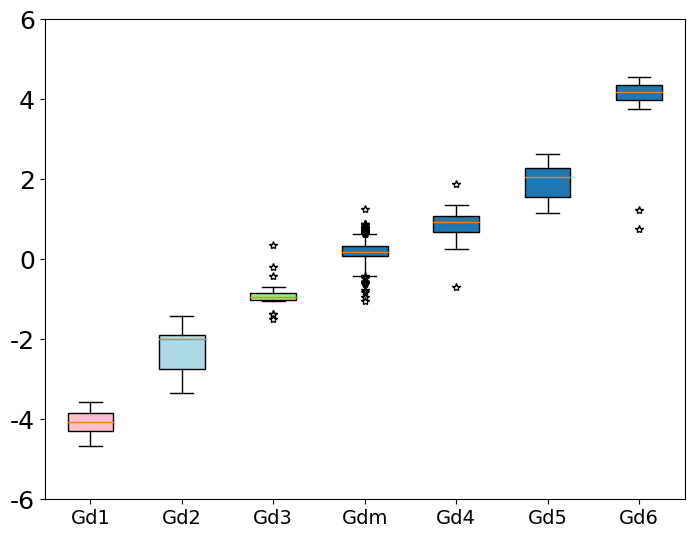

In [33]:
if __name__ == '__main__':
    PeakFormer_path = 'data/Mine/TOFShift/areas.csv'
    benchmark_path = 'data/FeatureTOFShift.csv'
    output_path = 'data/Mine/TOFShift/post-my-tof.csv'
    type = 'TOFShift'
    df = filter_duplicate(PeakFormer_path, benchmark_path)
    df1 = post_process(df, benchmark_path)
    plot_log(df1, type, 'PeakFormer', output_path)

In [34]:
import pandas as pd


def plot_CV_figure(path_A, path_B, path_C, type):
    # mzmine
    df1 = pd.read_csv(path_A)
    # peakdetective
    df2 = pd.read_csv(path_B)
    df2 = df2[(df2 != 0).all(axis=1)] 
    # msdetr
    df3 = pd.read_csv(path_C)

    plotCV(df1, df2, df3, type)


def plotCV(df1, df2, df3, type):
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    graph = ax.boxplot(
        [
            df1['CV-A'],
            df1['CV-B'],
            df2['CV-A'],
            df2['CV-B'],
            df3['CV-A'],
            df3['CV-B'],

        ],
        vert=True,
        patch_artist=True,
        labels=["SA", "SB", "SA", "SB", "SA", "SB"],
        sym='*'
    )
    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(graph['boxes'], colors):
        patch.set_facecolor(color)
    # ax.set_ylim(0, 200)
    ax.tick_params(axis='both', labelsize=14)
    plt.tight_layout()
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    plt.savefig(f"{type}_CV.png", dpi=300, bbox_inches="tight")
    plt.show()

/tmp/ipykernel_22219/3225530818.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/3225530818.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


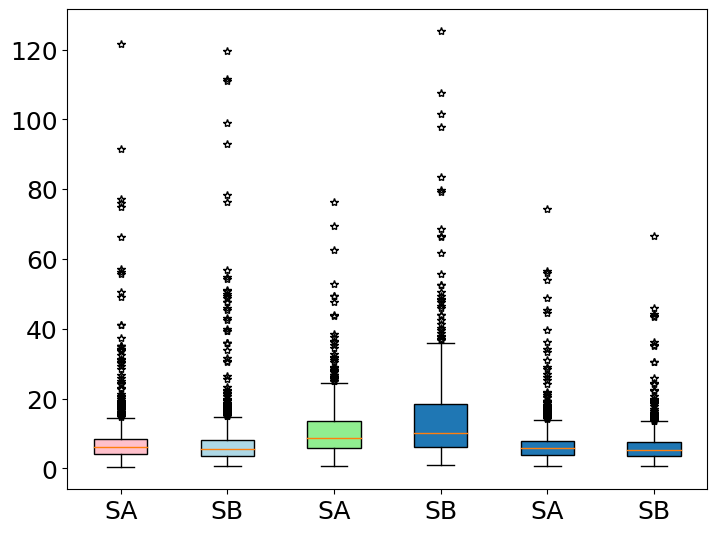

In [35]:
if __name__ == '__main__':
    plot_CV_figure(
    
        'data/MZMINE3/QE.csv',
        'data/PEAKDETECTIVE/peakdetective_QE.csv',
        'data/Mine/QE/post-my-qe.csv',
        'QE'
    )

/tmp/ipykernel_22219/3225530818.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/3225530818.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


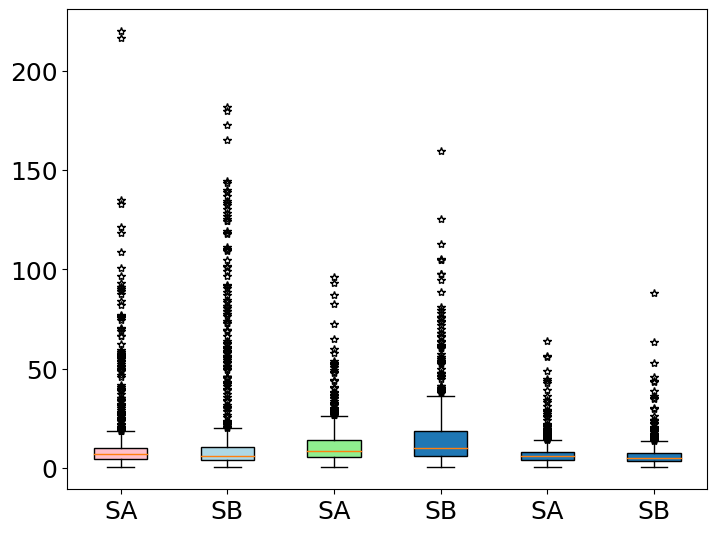

In [40]:
if __name__ == '__main__':
    plot_CV_figure(
    
        'data/MZMINE3/QEShift.csv',
        'data/PEAKDETECTIVE/peakdetective_QEShift.csv',
        'data/Mine/QEShift/post-my-qe.csv',
        'QEShift'
    )

/tmp/ipykernel_22219/3225530818.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/3225530818.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


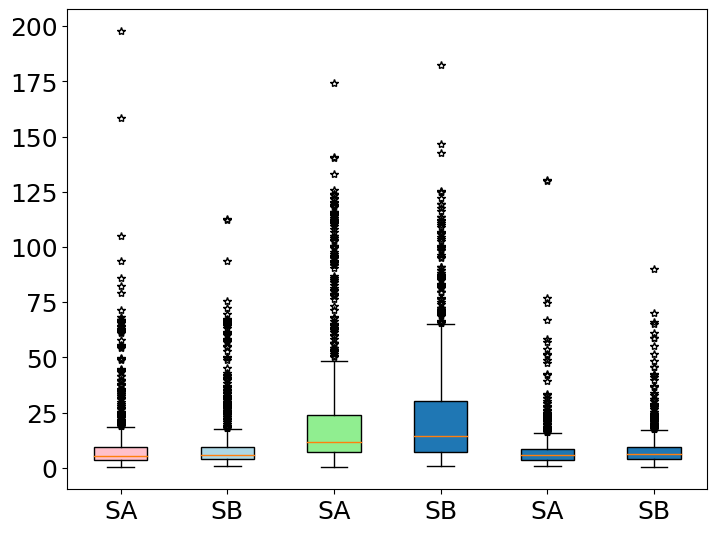

In [38]:
if __name__ == '__main__':
    plot_CV_figure(
    
        'data/MZMINE3/TOF.csv',
        'data/PEAKDETECTIVE/peakdetective_TOF.csv',
        'data/Mine/TOF/post-my-tof.csv',
        'TOF'
    )

/tmp/ipykernel_22219/3225530818.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22219/3225530818.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


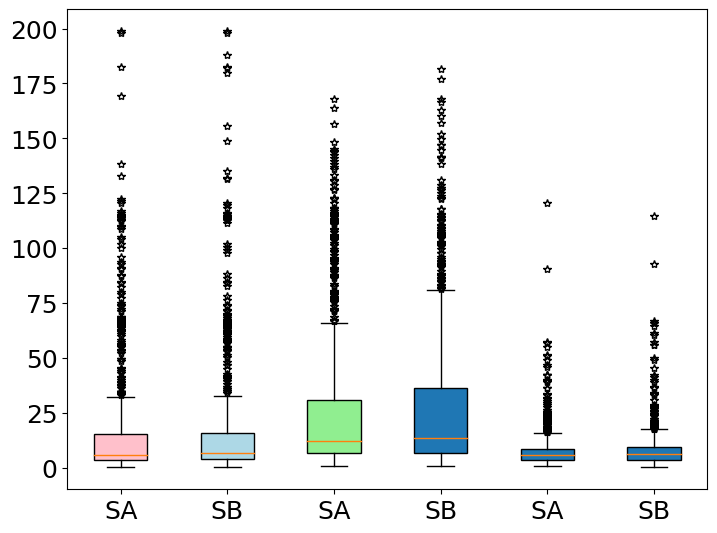

In [39]:
if __name__ == '__main__':
    plot_CV_figure(
    
        'data/MZMINE3/TOFShift.csv',
        'data/PEAKDETECTIVE/peakdetective_TOFShift.csv',
        'data/Mine/TOFShift/post-my-tof.csv',
        'TOFShift'
    )